In [ ]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-11-20 02:28:08.578628: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 02:28:08.783486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-20 02:28:08.783524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 02:28:08.803712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-20 02:28:08.866638: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load training info

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_p5_n10000'
tag_Anoise = '_An_p1_n10000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [4]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

## Inference results: nbar=0.00011

In [11]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00011'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00011 1.414213562373095
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  1.41421356]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_nbar0.00011_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00011_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00011_pred.npy


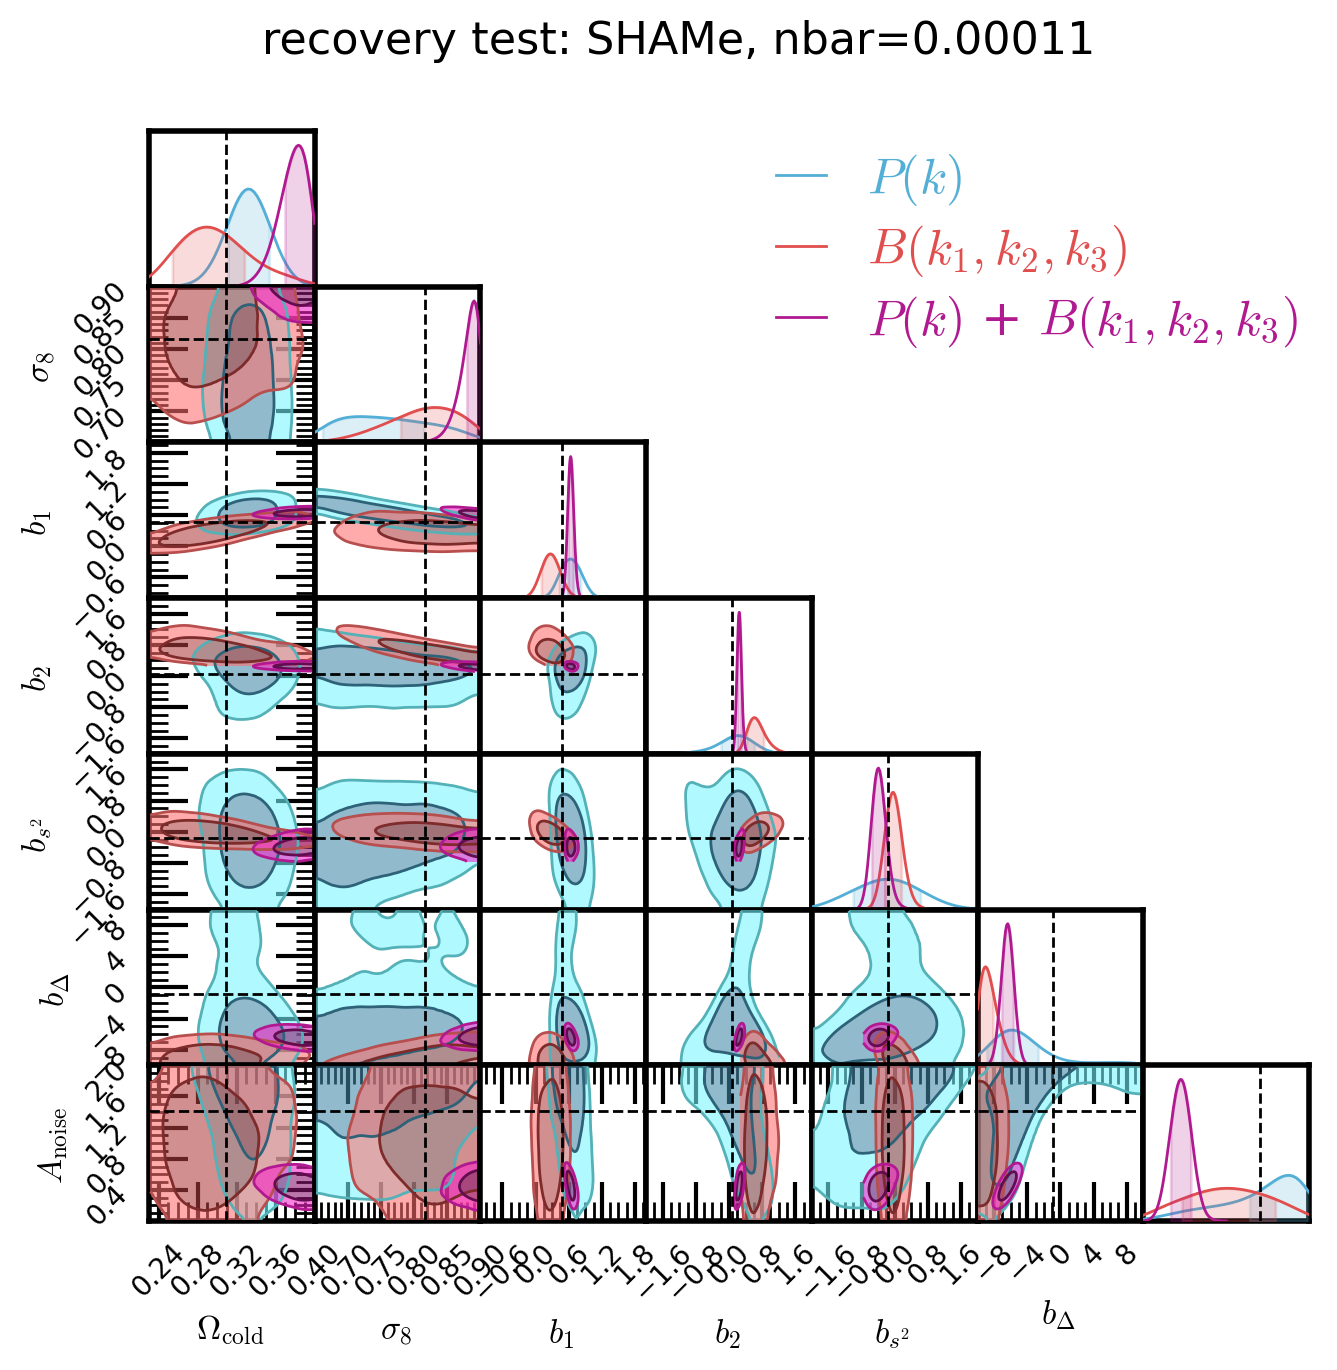

In [13]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Inference results: nbar=0.00022

In [14]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
#tag_mock = '_An1'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00022 1.0
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  1.        ]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


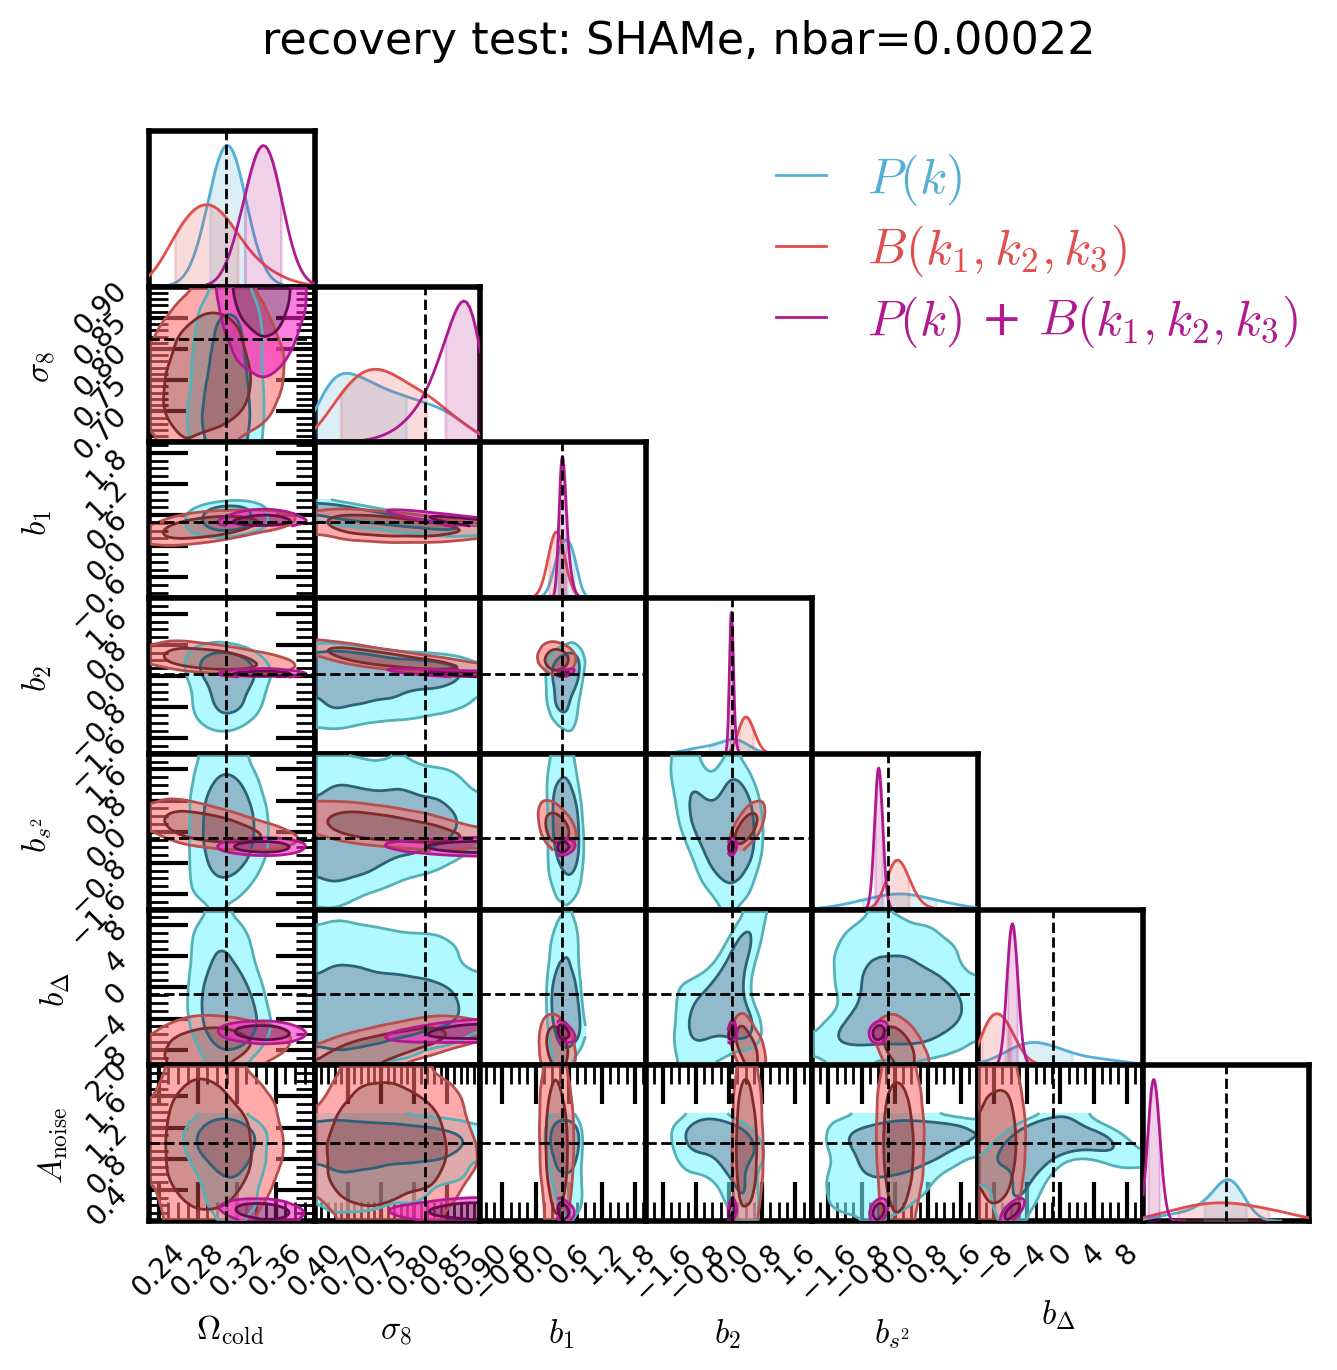

In [15]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Inference results: nbar=0.00054

In [16]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00054'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00054 0.6382847385042254
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  0.63828474]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_nbar0.00054_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00054_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00054_pred.npy


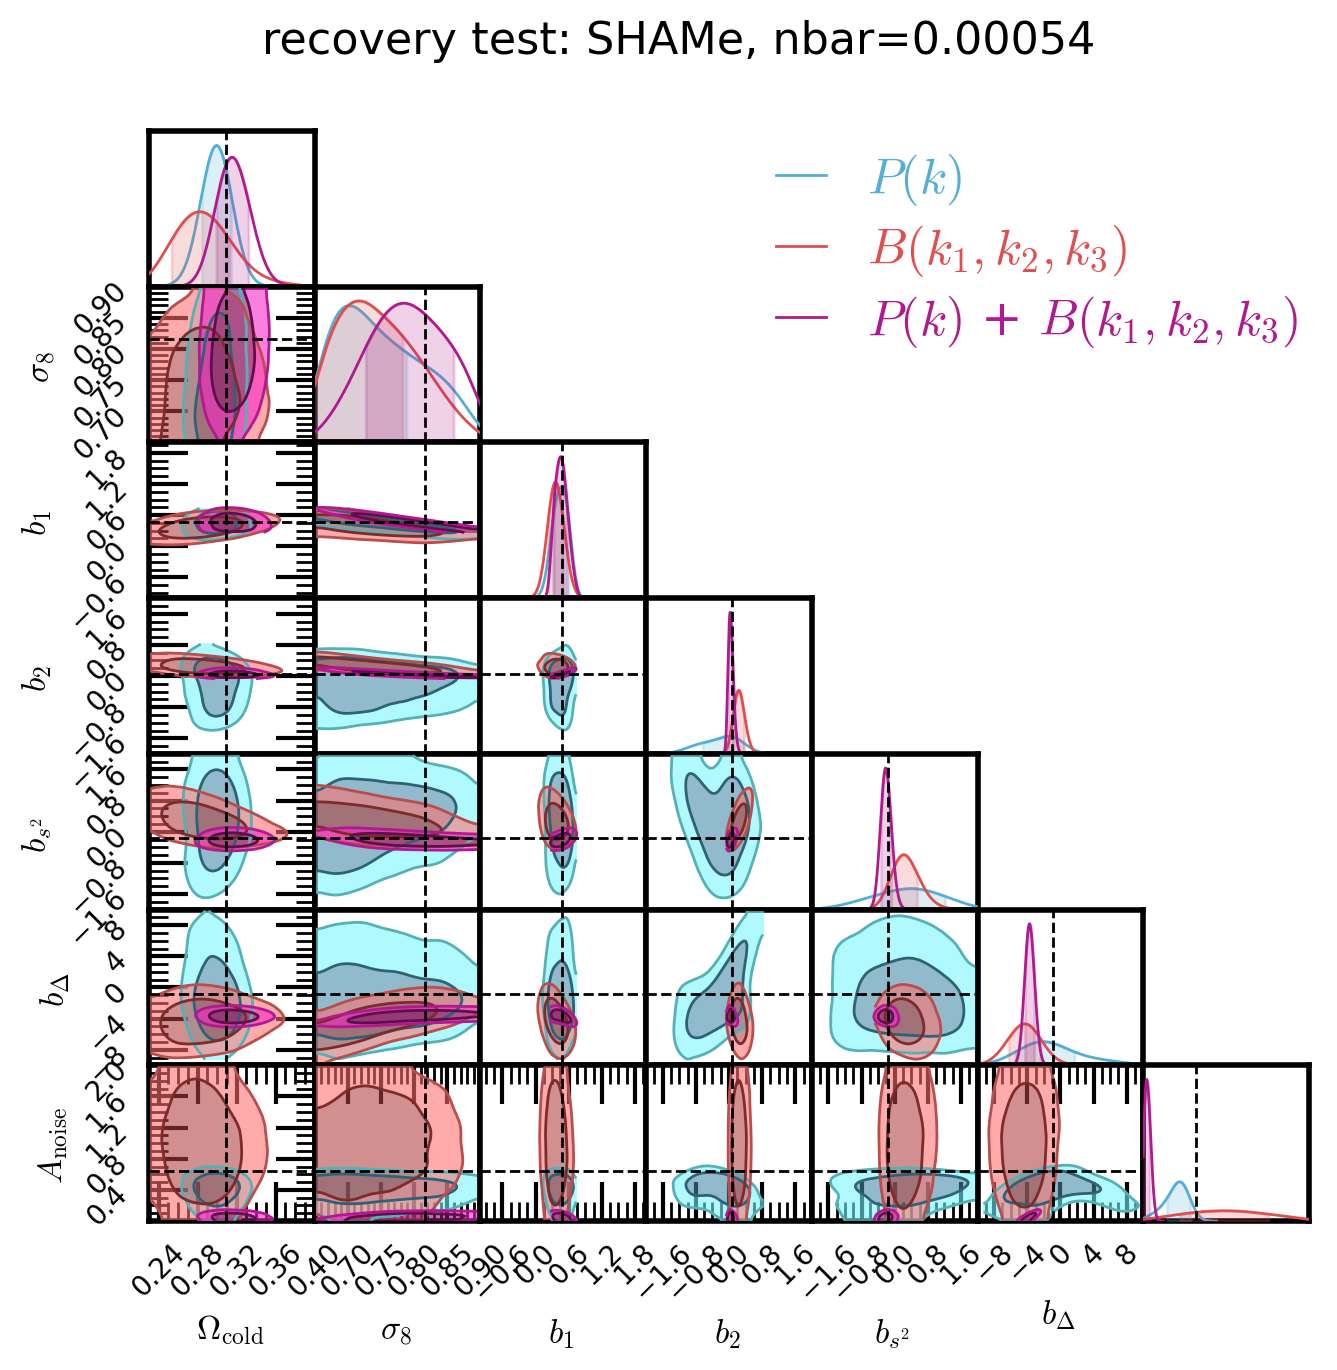

In [17]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Inference results: nbar=0.00022, fix Anoise=1 in training

In [18]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_p5_n10000'
tag_Anoise = '_An1_p0_n1' # fix Anoise=1

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [19]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

In [20]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00022 1.0
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  1.        ]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An1_p0_n1_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An1_p0_n1_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An1_p0_n1_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


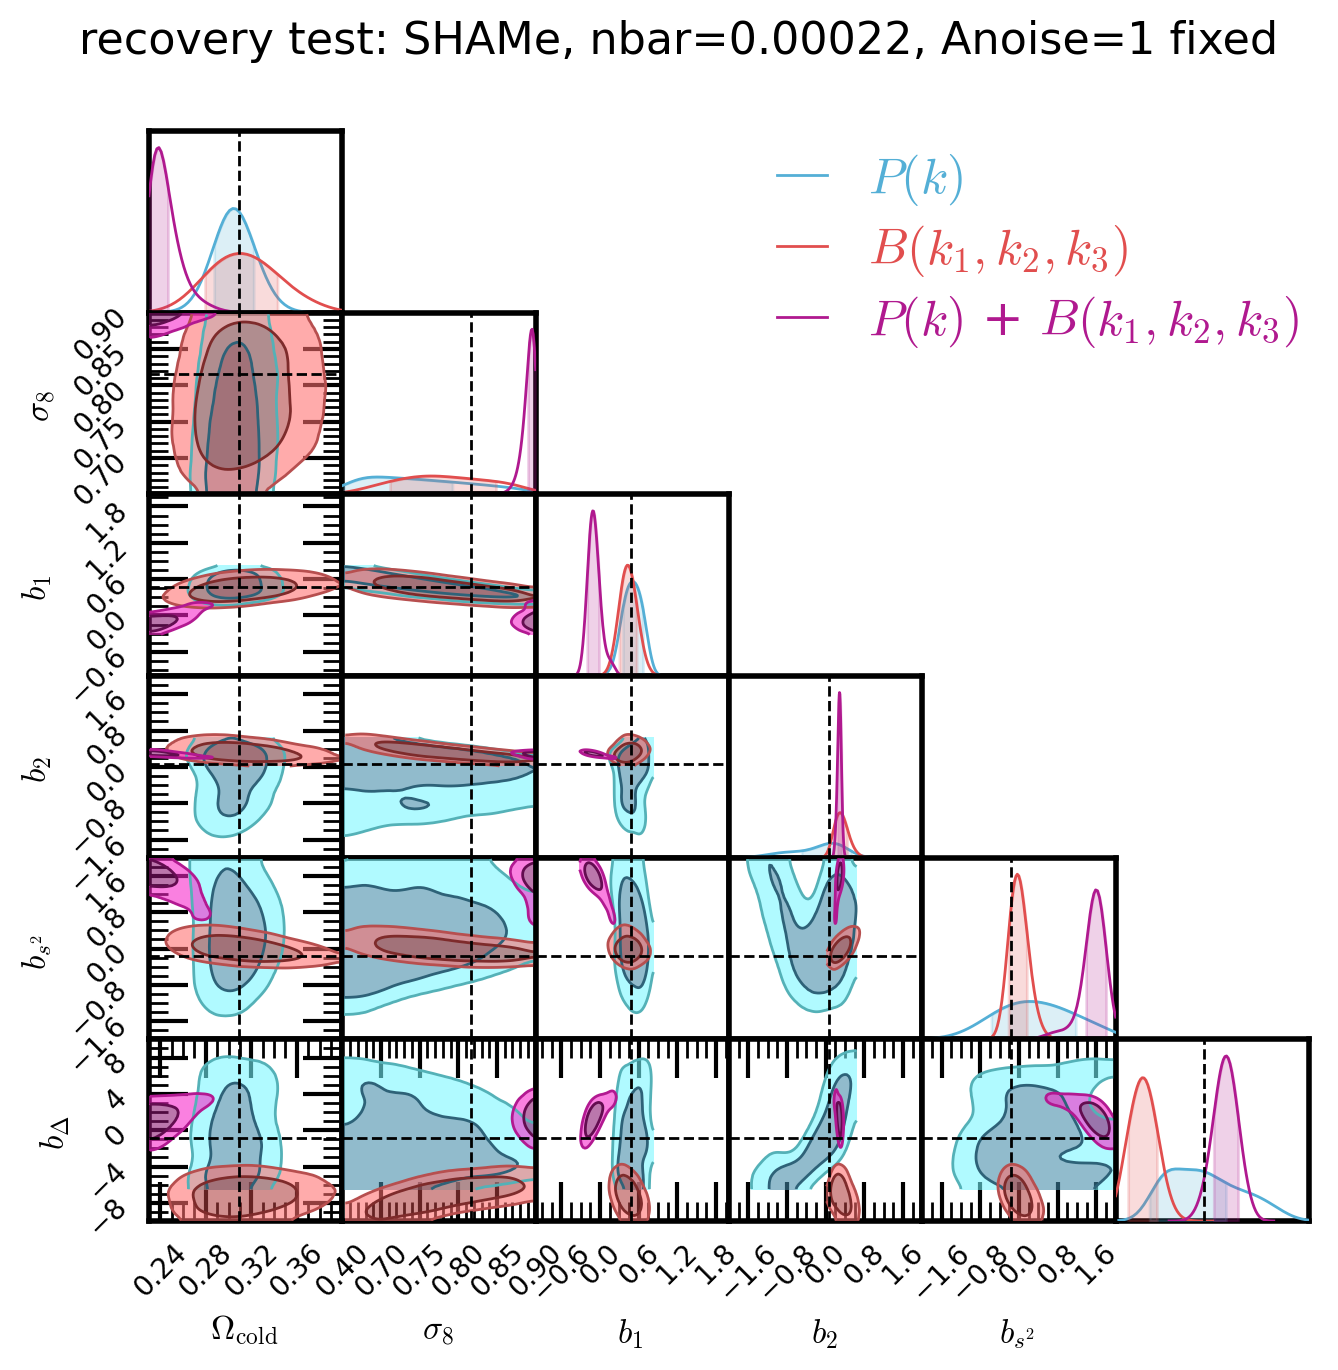

In [26]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}, Anoise=1 fixed'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Load catalogs

In [20]:
def compute_pk(tracer_field, cosmo, box_size,
               log_binning=True,
               normalise_grid=False, deconvolve_grid=False,
               interlacing=False, deposit_method='cic',
               correct_grid=False,
               n_threads=8, fn_stat=None):

    k_min = 0.01
    k_max = 1.0
    n_bins = 60
    
    # NOTE by default assumes tracer field is already normalized!

    # n_grid has to match the tracer field size for this compuation!
    n_grid = tracer_field.shape[-1]
    print("Computing pk, using n_grid = ", n_grid, flush=True)

    # defaults from bacco.statistics.compute_crossspectrum_twogrids
    # unless passed or otherwise denoted
    args_power_grid = {
        # "grid1": None,
        # "grid2": None,
        "normalise_grid1": normalise_grid, #default: False
        "normalise_grid2": normalise_grid, #default: False
        "deconvolve_grid1": deconvolve_grid, #default: False
        "deconvolve_grid2": deconvolve_grid, #default: False
        "ngrid": n_grid,
        "box": box_size,
        "mass1": None,
        "mass2": None,
        "interlacing": interlacing, #default: True
        "deposit_method": deposit_method, #default: "tsc",
        "log_binning": log_binning,
        "pk_lt": None,
        "kmin": k_min,
        "kmax": k_max,
        "nbins": n_bins,
        "correct_grid": correct_grid,
        "zspace": False,
        "cosmology": cosmo,
        "pmulti_interp": "polyfit",
        "nthreads": n_threads,
        "compute_correlation": False, #default: True
        "compute_power2d": False, #default: True
        "folds": 1,
        "totalmass1": None,
        "totalmass2": None,
        "jack_error": False,
        "n_jack": None
    }

    pknbody_dict = {
        'ngrid': n_grid,
        'min_k': k_min,
        'log_binning': log_binning,
        'log_binning_kmax': k_max,
        'log_binning_nbins': n_bins,
        'interlacing': interlacing,
        'depmethod': deposit_method,
        'correct_grid': correct_grid,
        'folds': 1 #default
    }
    bacco.configuration.update({'number_of_threads': n_threads})
    bacco.configuration.update({'pknbody': pknbody_dict})
    bacco.configuration.update({'pk' : {'maxk' : k_max}})
    bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})

    pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field,
                        grid2=tracer_field,
                        **args_power_grid)
    
    if fn_stat is not None:
        Path.absolute(Path(fn_stat).parent).mkdir(parents=True, exist_ok=True)
        np.save(fn_stat, pk_obj)
        
    return pk_obj

In [21]:
box_size_mock = 1024.0  # Mpc/h
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [22]:
data_mode = 'shame'

#tags_mock = ['_nbar0.00011', '_An1', '_nbar0.00054']
tags_mock = ['_An1_deconvolve']
pk_obj_arr = []
for tag_mock in tags_mock:

    fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
    fn_catpi_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phasepi.npy'
    tracer_field_0 = np.load(fn_cat0_mesh, allow_pickle=True)
    tracer_field_pi = np.load(fn_catpi_mesh, allow_pickle=True)
    
    pk_obj_0 = compute_pk(tracer_field_0, cosmo, box_size_mock, deconvolve_grid=False)
    pk_obj_pi = compute_pk(tracer_field_pi, cosmo, box_size_mock, deconvolve_grid=False)
    
    pk_obj = {}
    pk_obj['k'] = pk_obj_0['k']
    pk_obj['pk'] = 0.5*(pk_obj_0['pk'] + pk_obj_pi['pk'])  # average of phase=0 and phase=pi
    pk_obj['pk_gaussian_error'] = 0.5*(pk_obj_0['pk_gaussian_error'] + pk_obj_pi['pk_gaussian_error'])
    pk_obj_arr.append(pk_obj)

Computing pk, using n_grid =  132


2025-10-23 18:04:44,756 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2025-10-23 18:04:45,259 bacco.statistics :  ...done in 0.503 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -4.44669e-11 (grid1) -4.44669e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007022 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.100699 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000233 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 18:04:45,260 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 3.41314e-11 (grid1) 3.41314e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007105 sec
bacco.power : Counting modes


2025-10-23 18:04:45,372 bacco.statistics :  ...done in 0.112 s


bacco.power : done counting modes in 0.091536 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000387 secs
bacco.power : Deallocating arrays


In [23]:
box_size = 1000.0
n_grid = 128
# nbar from ELGs estimate in http://arxiv.org/abs/2307.09134, Pellejero-Ibanez et al. 2023
# "Hybrid-bias and displacement emulators for field-level modelling of galaxy clustering in real and redshift space"
# (ELGs: 2.3e-4)

#nbar_arr = [0.00011, 0.00022, 0.00054]
nbar_arr = [0.00022]
pk_obj_noise_arr = []
for nbar in nbar_arr:

    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)

    rng = np.random.default_rng(seed=42)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    
    pk_obj_noise = compute_pk(noise_field, cosmo, box_size)
    pk_obj_noise_arr.append(pk_obj_noise)

Computing pk, using n_grid =  128


2025-10-23 18:04:45,947 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-10-23 18:04:46,056 bacco.statistics :  ...done in 0.109 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002622 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.092203 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000401 secs
bacco.power : Deallocating arrays


In [24]:
nbar_fid = 0.00022

cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field_fid = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field_fid /= n_grid**3
    
pk_obj_noise_An_arr = []
for nbar in nbar_arr:

    A_noise = 1.0/np.sqrt(nbar/nbar_fid)

    pk_obj_noise_An = compute_pk(A_noise*noise_field_fid, cosmo, box_size)
    pk_obj_noise_An_arr.append(pk_obj_noise_An)

Computing pk, using n_grid =  128


2025-10-23 18:04:46,537 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-10-23 18:04:46,655 bacco.statistics :  ...done in 0.118 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002494 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079351 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000390 secs
bacco.power : Deallocating arrays


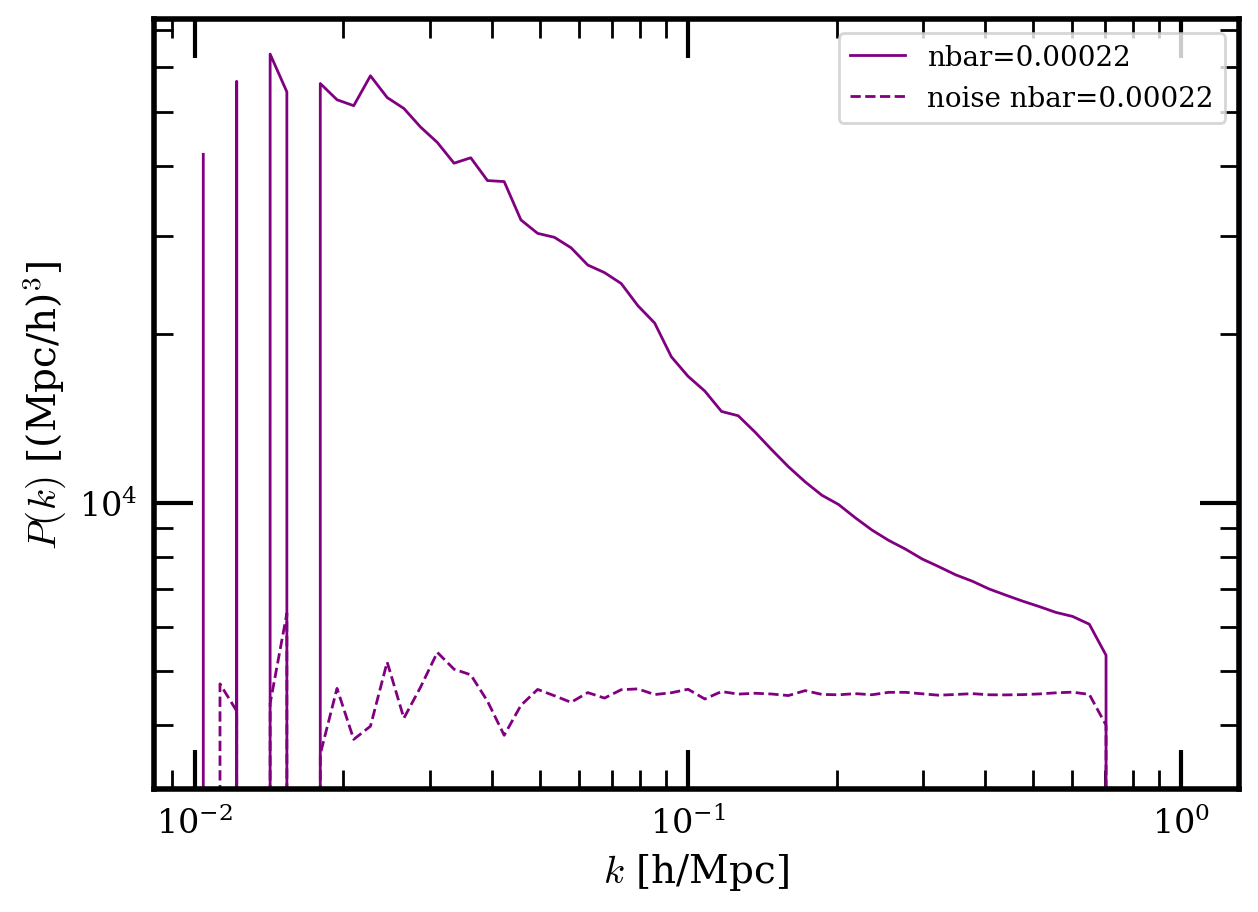

In [25]:
color_arr = ['purple', 'blue', 'green']
plt.figure(figsize=(7,5))
for i, tag_mock in enumerate(tags_mock):
    pk_obj = pk_obj_arr[i]

    plt.plot(pk_obj['k'], pk_obj['pk'], color=color_arr[i], label=f'nbar={nbar_arr[i]}', lw=1)
    plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=color_arr[i], ls='--', label=f'noise nbar={nbar_arr[i]}', lw=1)
    #plt.plot(pk_obj_noise_An_arr[i]['k'], pk_obj_noise_An_arr[i]['pk'], color=color_arr[i], ls=':', label=f'noise A*nbar={nbar_arr[i]}', lw=1)
    
    #plt.fill_between(pk_obj['k'], pk_obj['pk'] - pk_obj['pk_gaussian_error'], pk_obj['pk'] + pk_obj['pk_gaussian_error'], color='gray', alpha=0.5, label='gaussian error')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=10)

# Check forward model

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
tag_mock = None # cosmo is the same for all shame mocks
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
n_grid_orig = 512 # this is for the muchisimocks pipeline which is 512, even tho the shame tracer field was diff (n_grid_orig_mock)
tracer_field_noiseless = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                n_grid_norm=n_grid_orig)

## Add noise

In [7]:
nbar_fid = 0.00022

n_grid = 128
box_size = 1000.0  # Mpc/h
cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field_fid = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field_fid /= n_grid**3

In [8]:
A_noise = 1
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                      noise_field=noise_field_fid, A_noise=A_noise, n_grid_norm=n_grid_orig)

In [ ]:
nbar_hi = 0.00054

n_grid = 128
box_size = 1000.0  # Mpc/h
cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field_hi = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field_hi /= n_grid**3

In [50]:
A_noise = 1
tracer_field_hi = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                      noise_field=noise_field_hi, A_noise=A_noise, n_grid_norm=n_grid_orig)

In [9]:
box_size = 1000.0
pk_obj_noiseless = cs.compute_pk(tracer_field_noiseless, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 16:52:04,479 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 16:52:06,086 bacco.statistics :  ...done in 1.61 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.018049 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043690 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays


In [ ]:
box_size = 1000.0
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 16:52:06,509 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 16:52:06,582 bacco.statistics :  ...done in 0.0737 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014276 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042276 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


In [51]:
box_size = 1000.0
pk_obj_hi = cs.compute_pk(tracer_field_hi, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 17:20:50,774 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 17:20:50,853 bacco.statistics :  ...done in 0.0793 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013853 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043293 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays


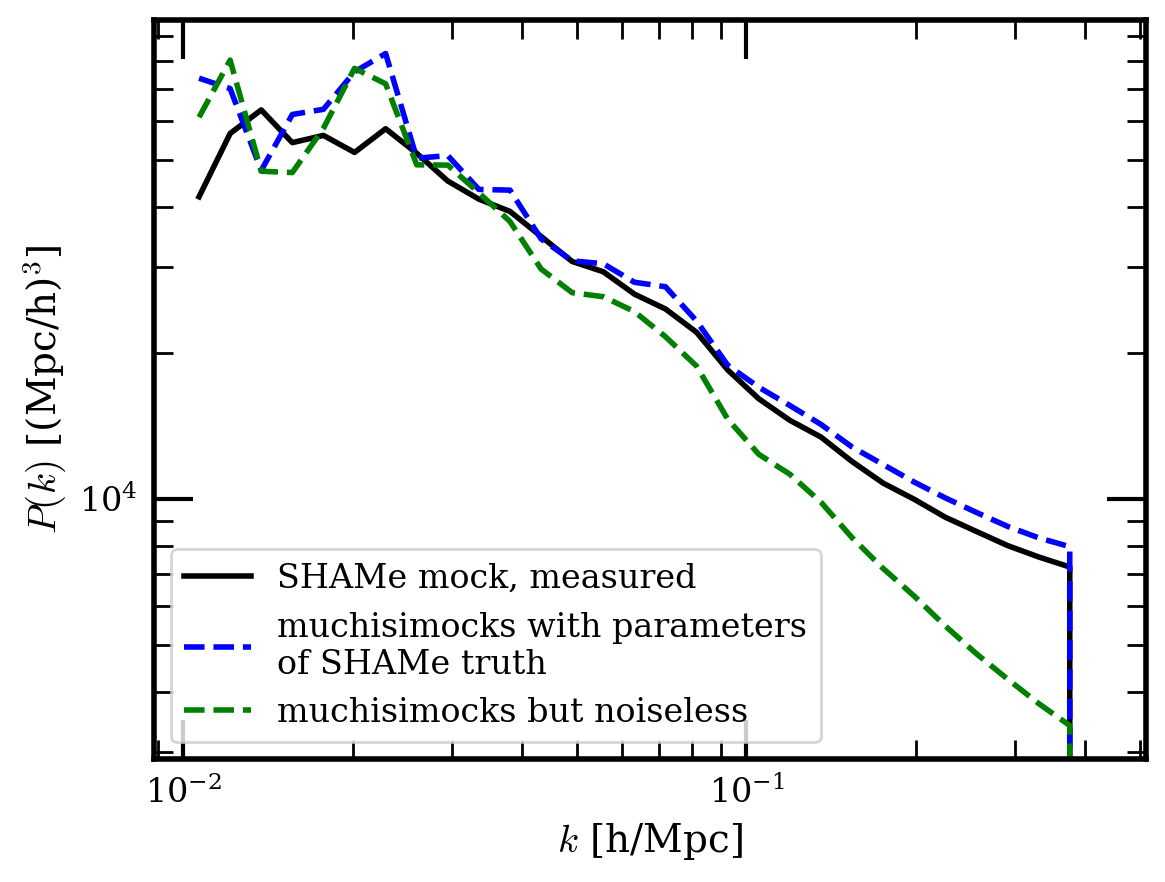

In [ ]:
plt.plot(k_mock[0], y_mock[0], color='black', label='SHAMe mock, measured', lw=2)
plt.plot(pk_obj['k'], pk_obj['pk'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth', lw=2)
plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='green', ls='--', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

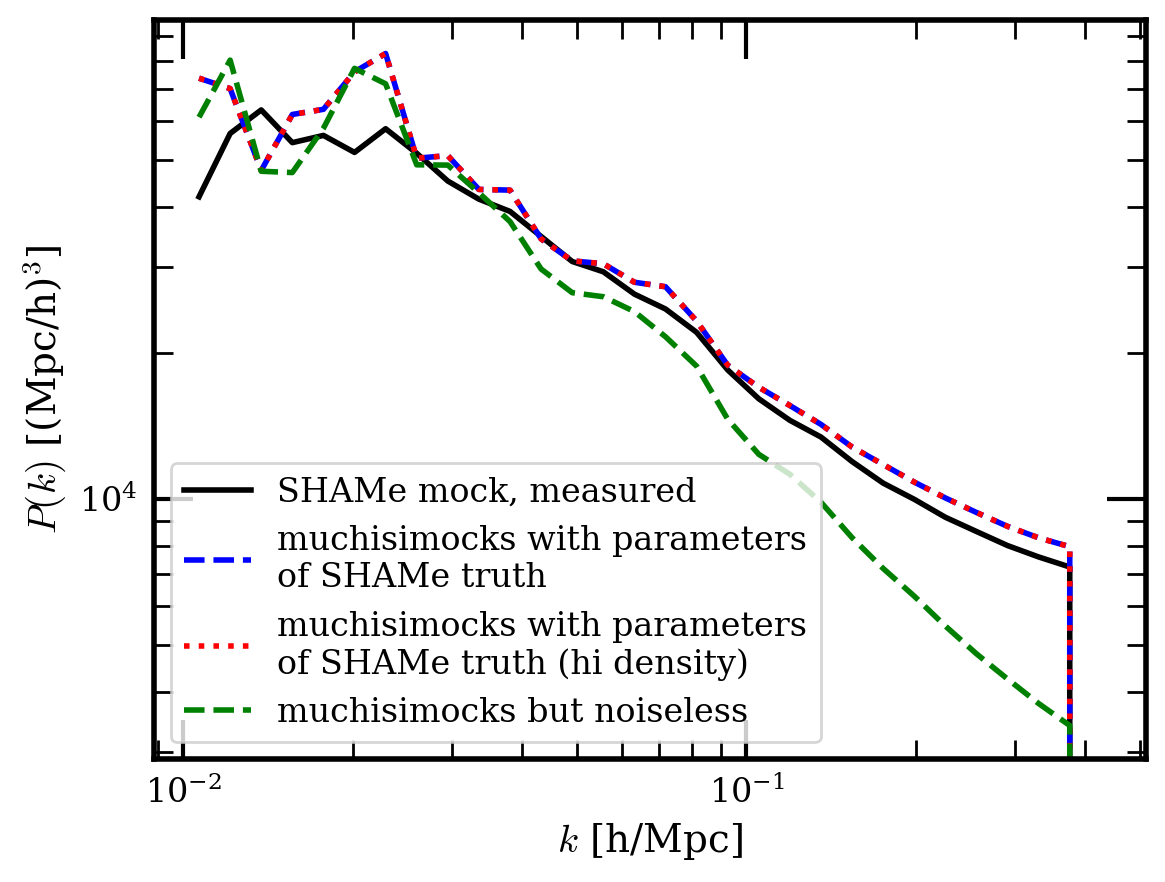

In [ ]:
plt.plot(k_mock[0], y_mock[0], color='black', label='SHAMe mock, measured', lw=2)
plt.plot(pk_obj['k'], pk_obj['pk'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth', lw=2)
plt.plot(pk_obj_hi['k'], pk_obj_hi['pk'], color='red', ls=':', label='muchisimocks with parameters\nof SHAMe truth (hi density)', lw=2)
plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='green', ls='--', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

In [12]:
print(box_size, n_grid)

1000.0 128


In [13]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.55 s


In [14]:
bspec, bk_corr = cs.compute_bispectrum(base, tracer_field)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [15]:
bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [16]:
box_size_mock = 1024.0
import process_catalogs as pc
n_grid_mock = pc.round_to_nearest_even(box_size_mock / (box_size/n_grid))
print("n_grid_mock: ", n_grid_mock)

n_grid_mock:  132


In [17]:
print(n_grid)

128


2097152 2299968


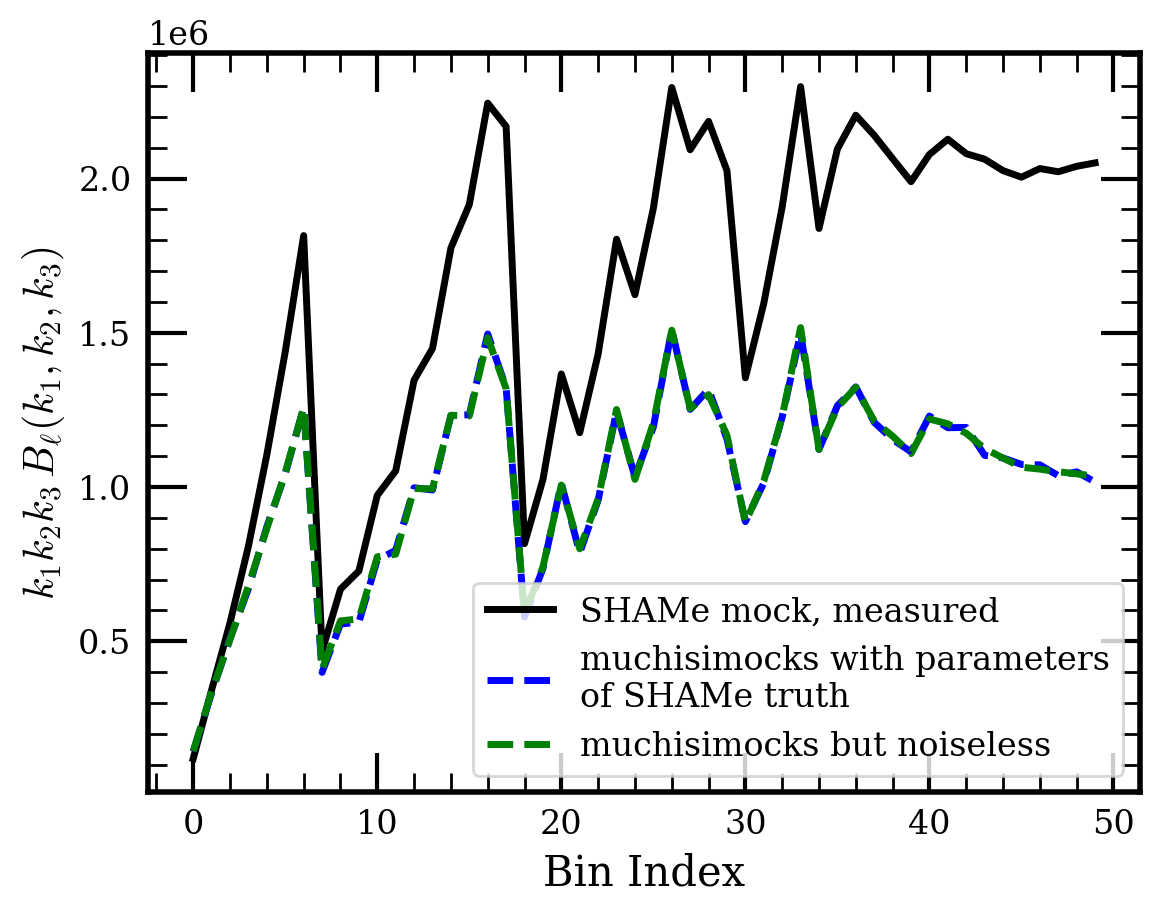

In [18]:
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

plt.plot(y_mock[1], color='black', label='SHAMe mock, measured')
plt.plot(norm**3 * weight*bk_corr['b0'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth')
plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='green', ls='--', label='muchisimocks but noiseless')


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

In [56]:
data_mode_test = 'shame'
tag_mock_hi = '_nbar0.00054'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock_hi, y_mock_hi, y_err_mock_hi = data_loader.load_data_ood(data_mode_test, statistics, tag_mock_hi, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


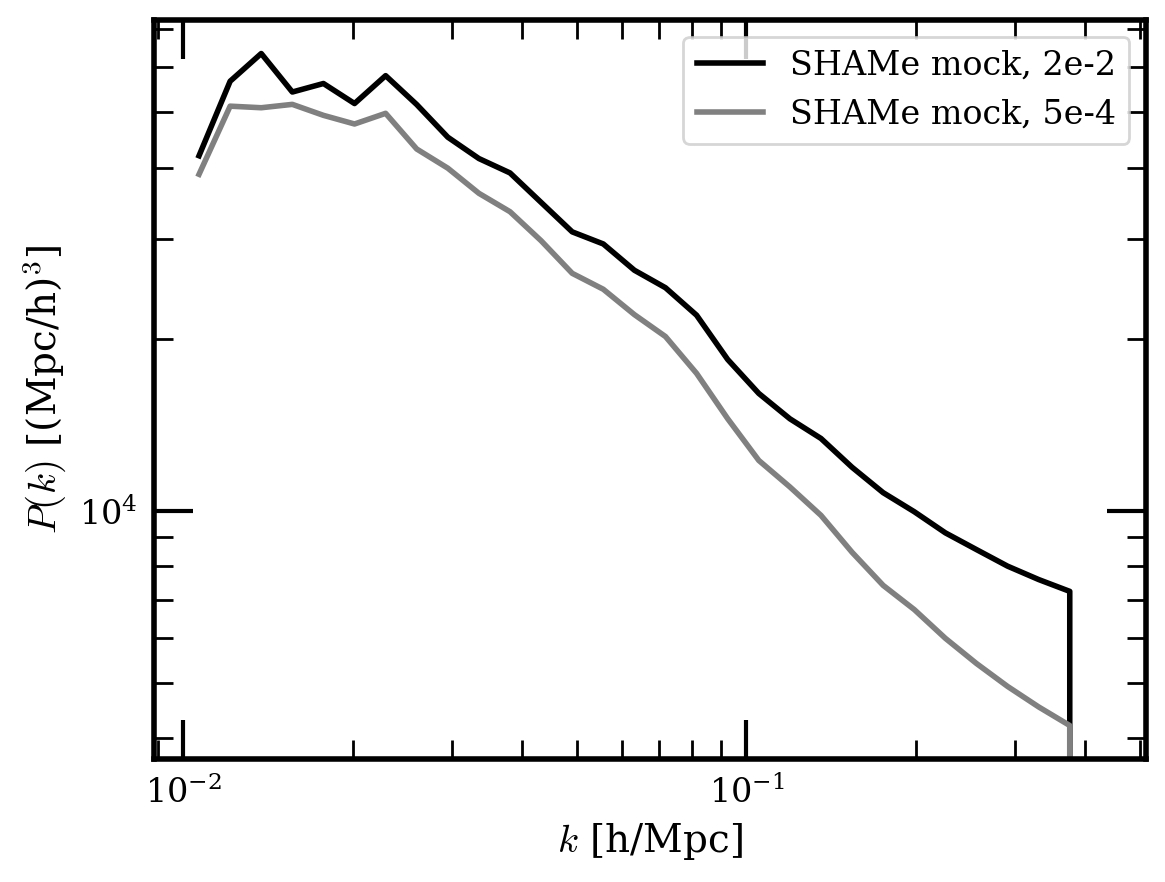

In [57]:
plt.plot(k_mock[0], y_mock[0], color='black', label='SHAMe mock, 2e-2', lw=2)
plt.plot(k_mock_hi[0], y_mock_hi[0], color='grey', label='SHAMe mock, 5e-4', lw=2)
#plt.plot(pk_obj['k'], pk_obj['pk'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth', lw=2)
#plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='green', ls='--', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

2097152 2299968


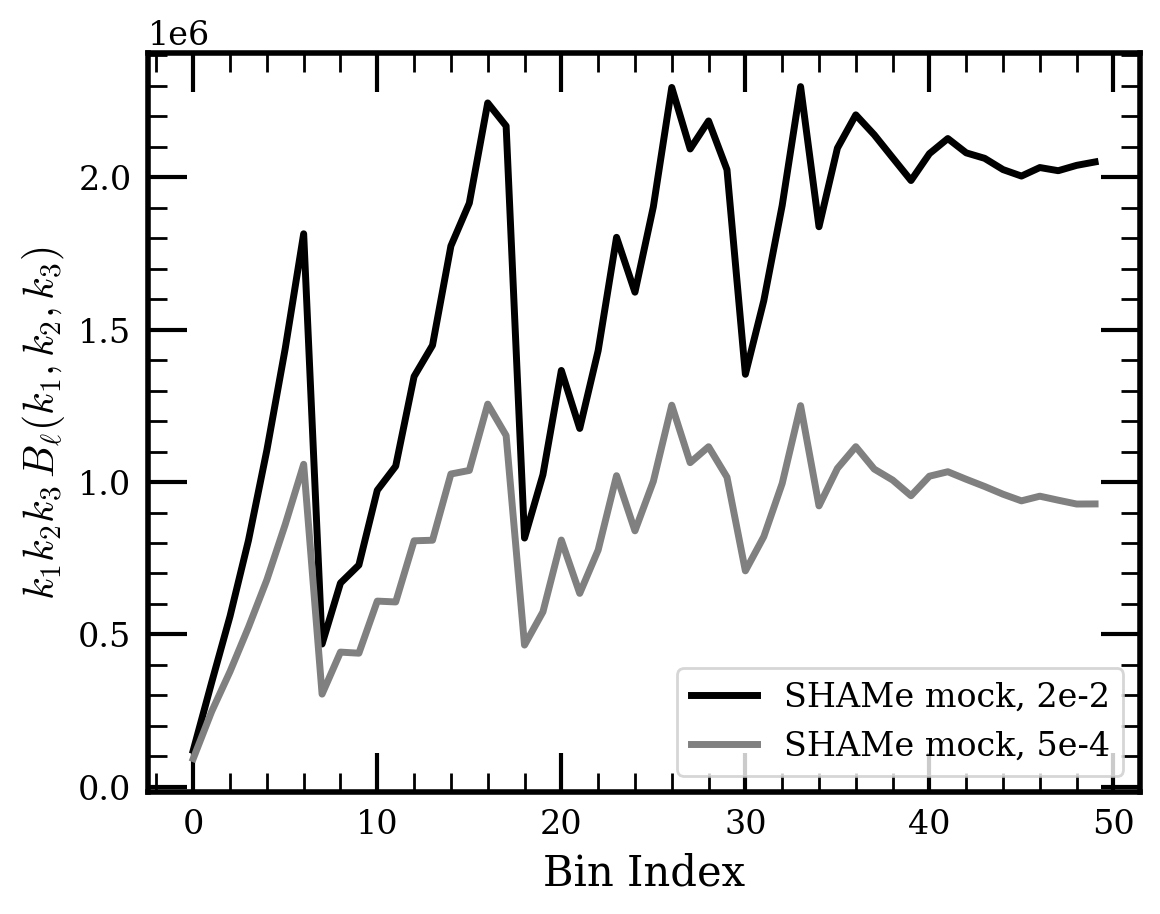

In [58]:
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

plt.plot(y_mock[1], color='black', label='SHAMe mock, 2e-2')
plt.plot(y_mock_hi[1], color='grey', label='SHAMe mock, 5e-4')
#plt.plot(norm**3 * weight*bk_corr['b0'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth')
#plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='green', ls='--', label='muchisimocks but noiseless')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

## Try diff noise model

In [19]:
# nbar_fid = 0.00022

# n_grid = 128
# box_size = 1000.0  # Mpc/h
# cell_size = box_size / n_grid  # Mpc/h per cell
# cell_volume = cell_size**3
# rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

# rng = np.random.default_rng(seed=42)

# noise_field_fid = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
# noise_field_fid /= n_grid**3

In [20]:
nbar_fid = 0.00022
n_grid = 128
cell_size = box_size / n_grid  
cell_volume = cell_size**3

# Shot noise amplitude
rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

# EFT stochasticity parameters
sigma_eps_0 = rms_cell
sigma_eps_k2 = 5.0  # Set to 0 to match your original, or 50.0 for EFT

rng = np.random.default_rng(seed=42)

# Get k-space grid
kx = np.fft.fftfreq(n_grid, d=cell_size) * 2*np.pi
ky = np.fft.fftfreq(n_grid, d=cell_size) * 2*np.pi
kz = np.fft.fftfreq(n_grid, d=cell_size) * 2*np.pi
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
k = np.sqrt(KX**2 + KY**2 + KZ**2)

# Generate white noise in real space first
noise_field_kdep = rng.standard_normal((n_grid, n_grid, n_grid))

# If we want k-dependence, transform to Fourier space and apply
if sigma_eps_k2 > 0:
    noise_k = np.fft.fftn(noise_field_kdep)
    
    # Apply k-dependent amplitude modulation
    # sigma(k) / sigma(0) = sqrt(1 + sigma_eps_k2 * k^2)
    k_factor = np.sqrt(1 + sigma_eps_k2 * k**2)
    noise_k *= k_factor
    
    # Transform back
    noise_field_kdep = np.fft.ifftn(noise_k).real

# Apply overall normalization (your original convention)
noise_field_kdep = (sigma_eps_0 / n_grid**3) * noise_field_kdep

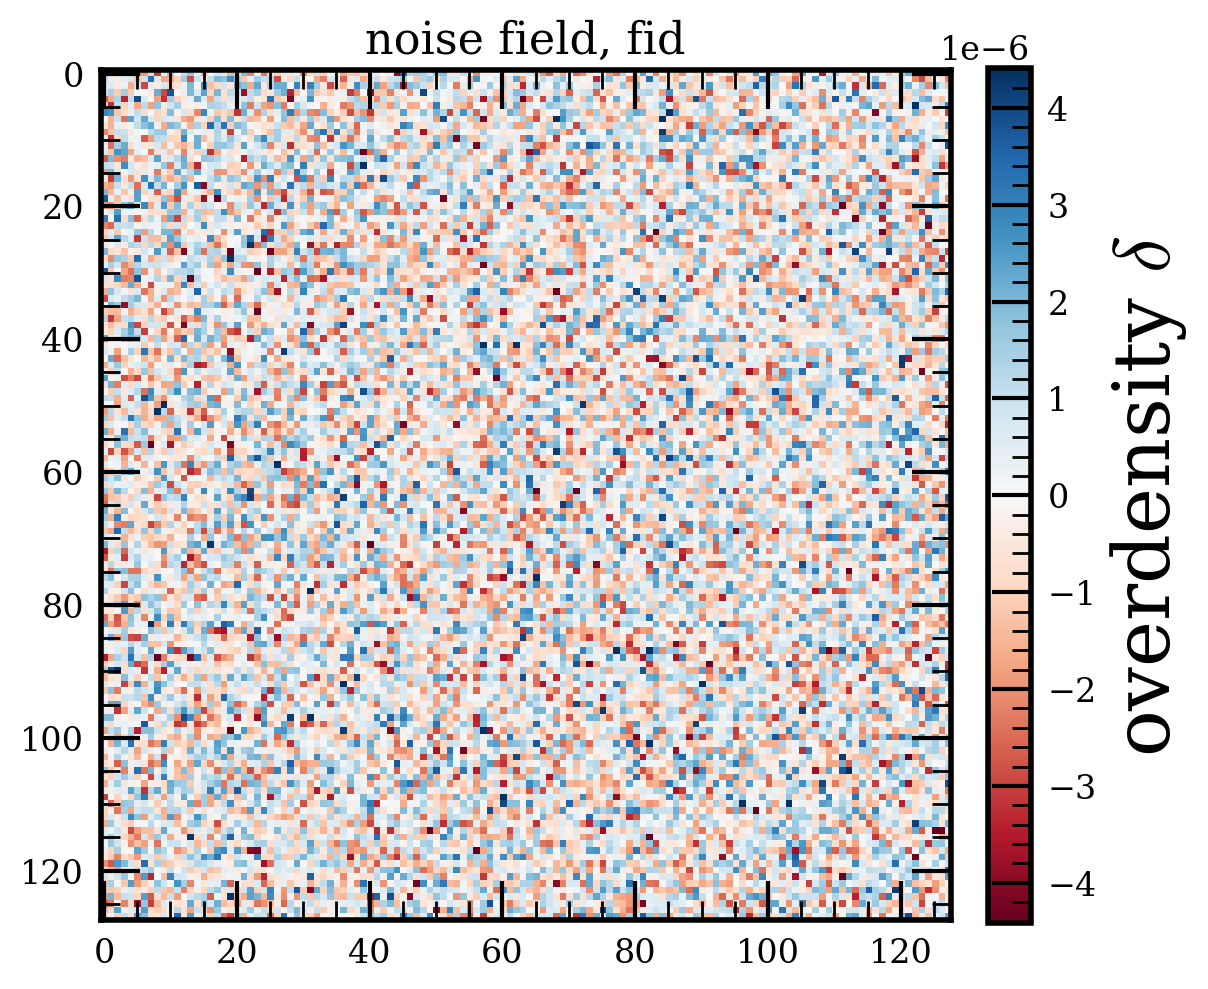

In [21]:
plotter.plot_overdensity_field(noise_field_fid, title='noise field, fid')

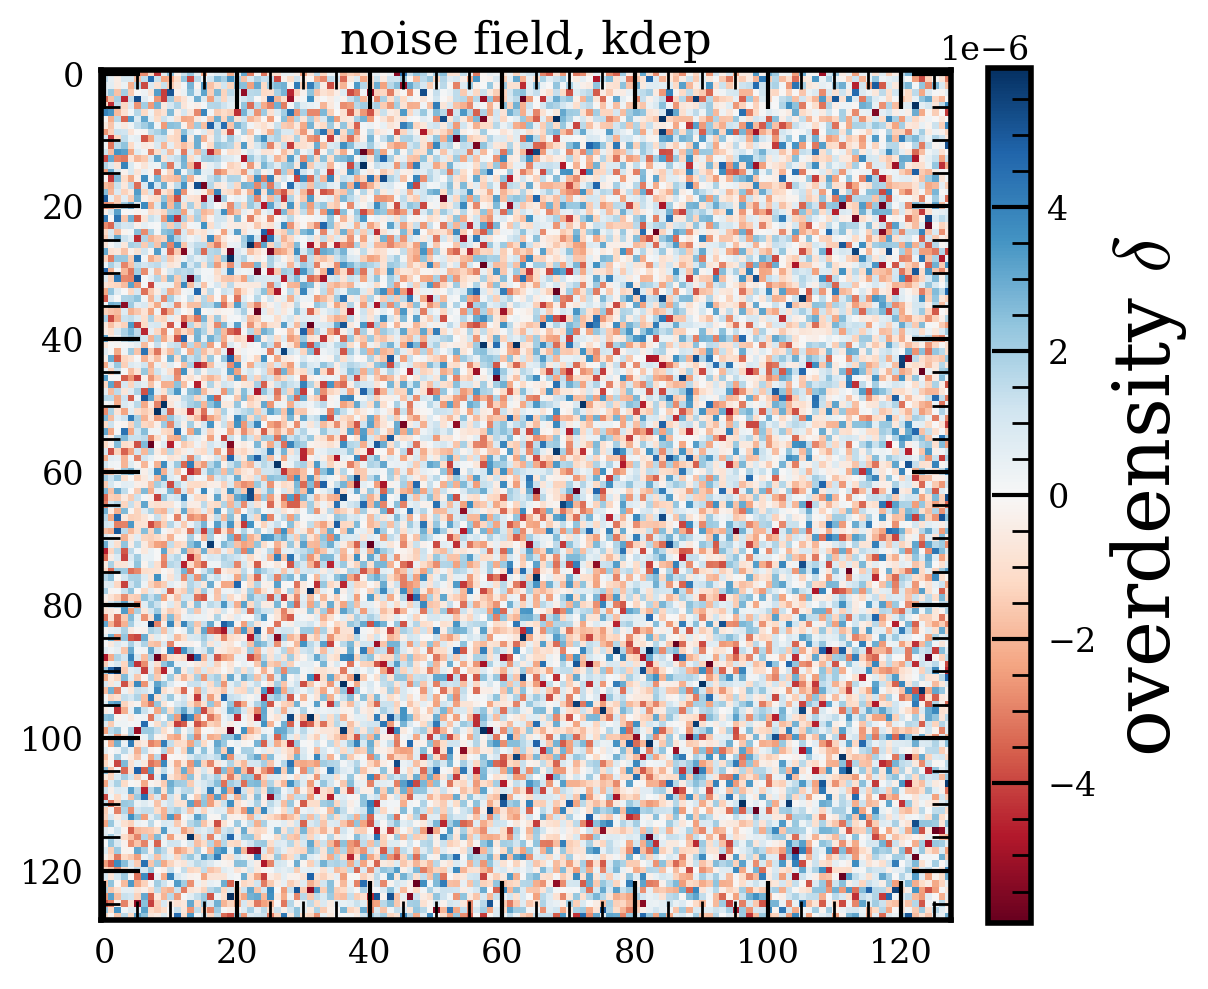

In [22]:
plotter.plot_overdensity_field(noise_field_kdep, title='noise field, kdep')

In [23]:
A_noise = 1
tracer_field_noisekdep = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                      noise_field=noise_field_kdep, A_noise=A_noise, n_grid_norm=n_grid_orig)

In [24]:
box_size = 1000.0
pk_obj_noisekdep = cs.compute_pk(tracer_field_noisekdep, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 16:52:20,765 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 16:52:20,844 bacco.statistics :  ...done in 0.0789 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013883 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042577 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays


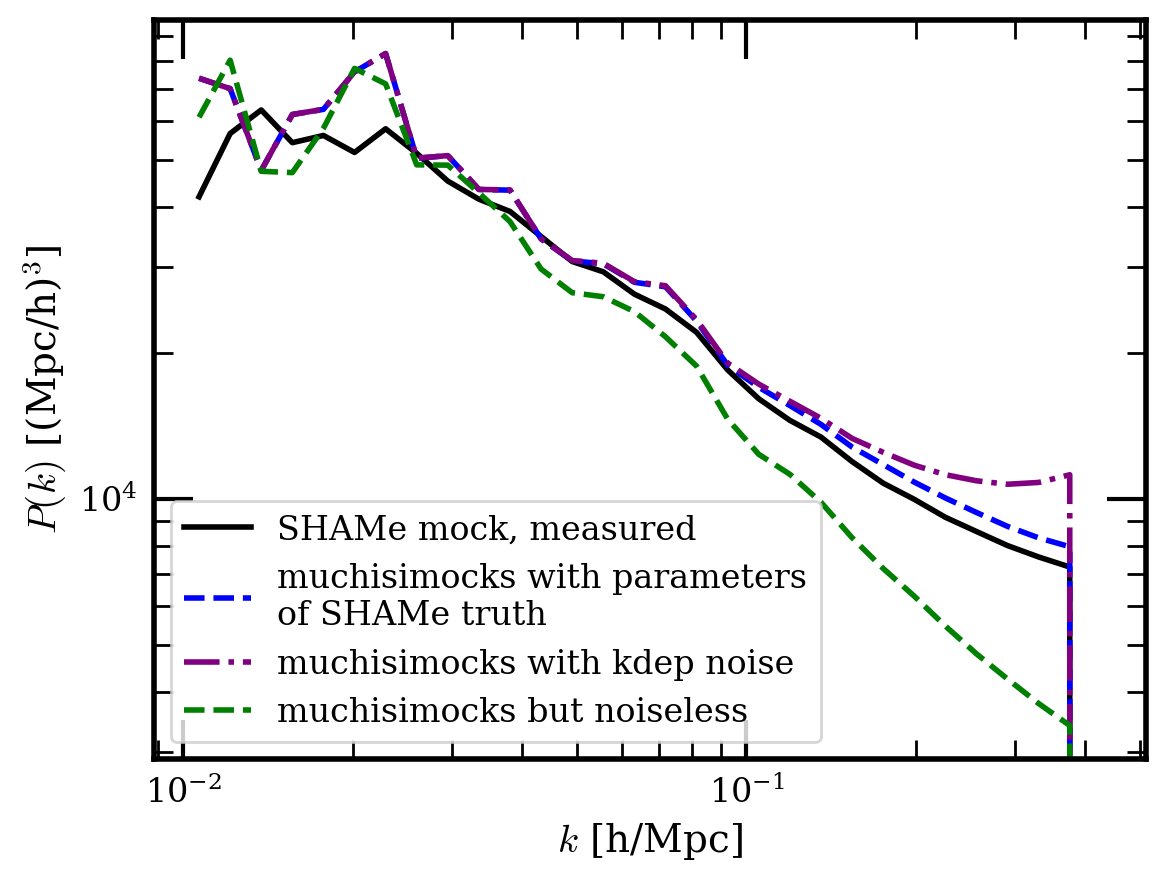

In [25]:
plt.plot(k_mock[0], y_mock[0], color='black', label='SHAMe mock, measured', lw=2)
plt.plot(pk_obj['k'], pk_obj['pk'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth', lw=2)
plt.plot(pk_obj_noisekdep['k'], pk_obj_noisekdep['pk'], color='purple', ls='-.', label='muchisimocks with kdep noise', lw=2)
plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='green', ls='--', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

In [26]:
bspec_noisekdep, bk_corr_noisekdep = cs.compute_bispectrum(base, tracer_field_noisekdep)



Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


2097152 2299968


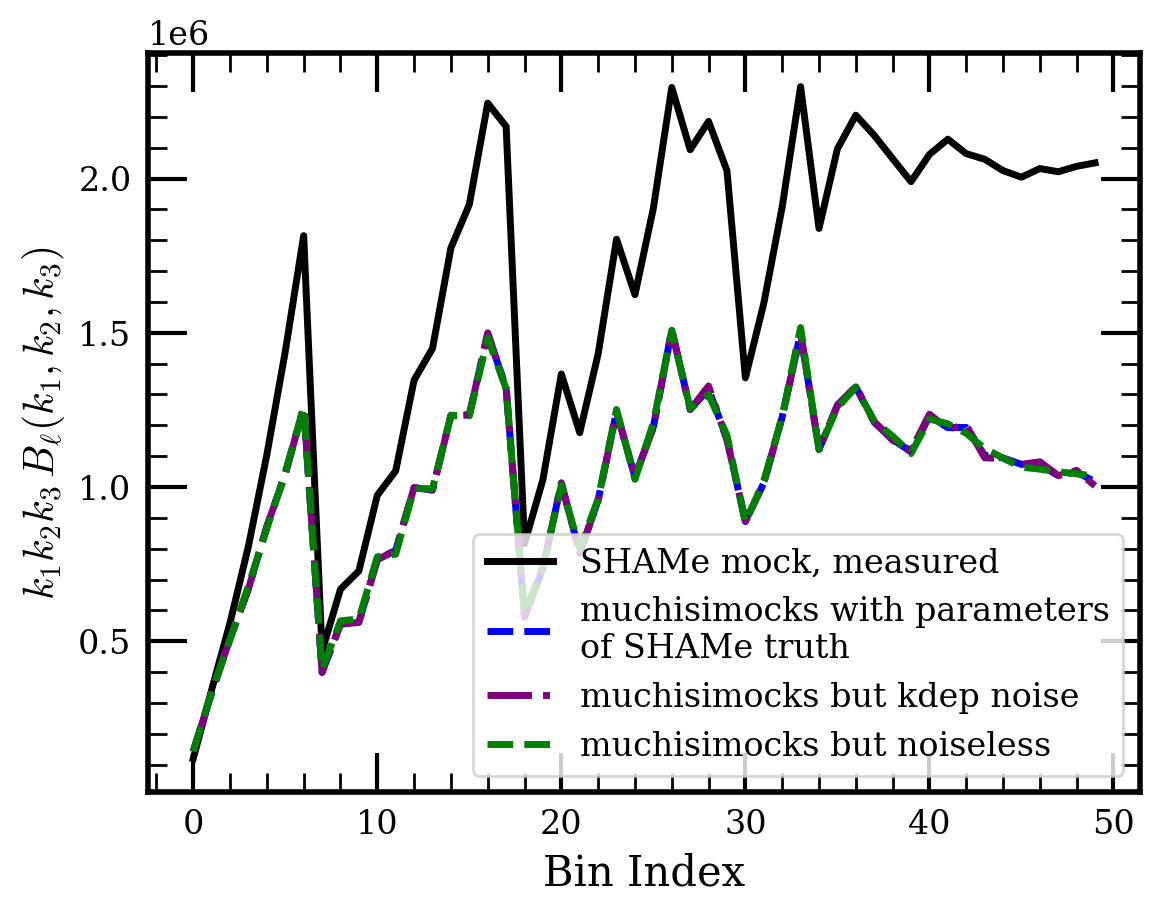

In [27]:
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

plt.plot(y_mock[1], color='black', label='SHAMe mock, measured')
plt.plot(norm**3 * weight*bk_corr['b0'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth')
plt.plot(norm**3 * weight*bk_corr_noisekdep['b0'], color='purple', ls='-.', label='muchisimocks but kdep noise')
plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='green', ls='--', label='muchisimocks but noiseless')


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

In [28]:
### try discrete sampling

In [44]:

# Expected number of galaxies per cell
n_expected = nbar_fid * cell_volume * (1 + tracer_field)

# Ensure non-negative (can happen in voids with negative tracer_field)
n_expected = np.maximum(n_expected, 0)

# Poisson sample
rng = np.random.default_rng(seed=42)
n_galaxies = rng.poisson(n_expected)

# Convert back to overdensity field
tracer_field_poisson = (n_galaxies / cell_volume) / nbar_fid - 1

tracer_field_poisson /= n_grid**3  # normalize

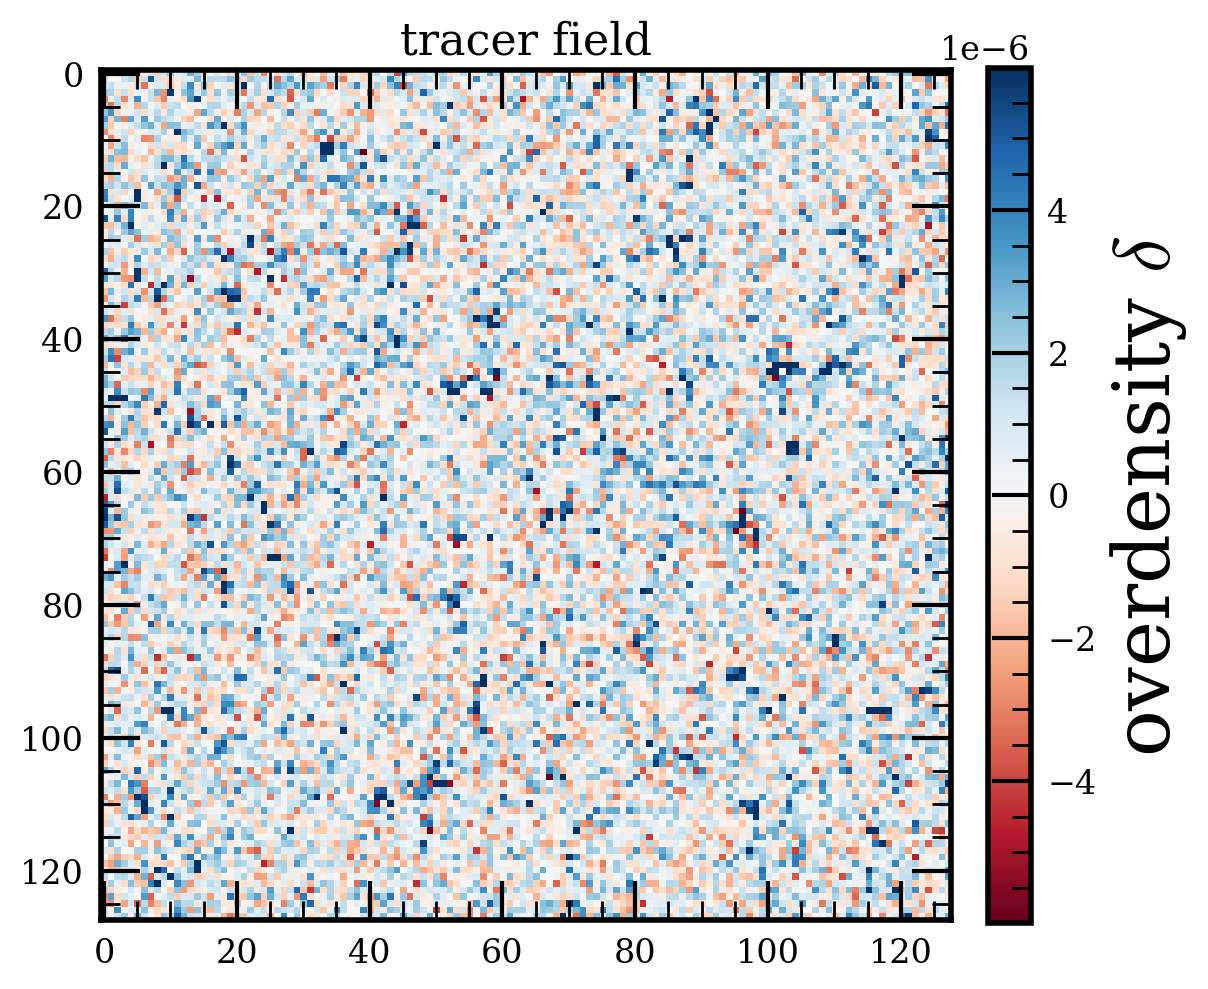

In [46]:
plotter.plot_overdensity_field(tracer_field, title='tracer field')

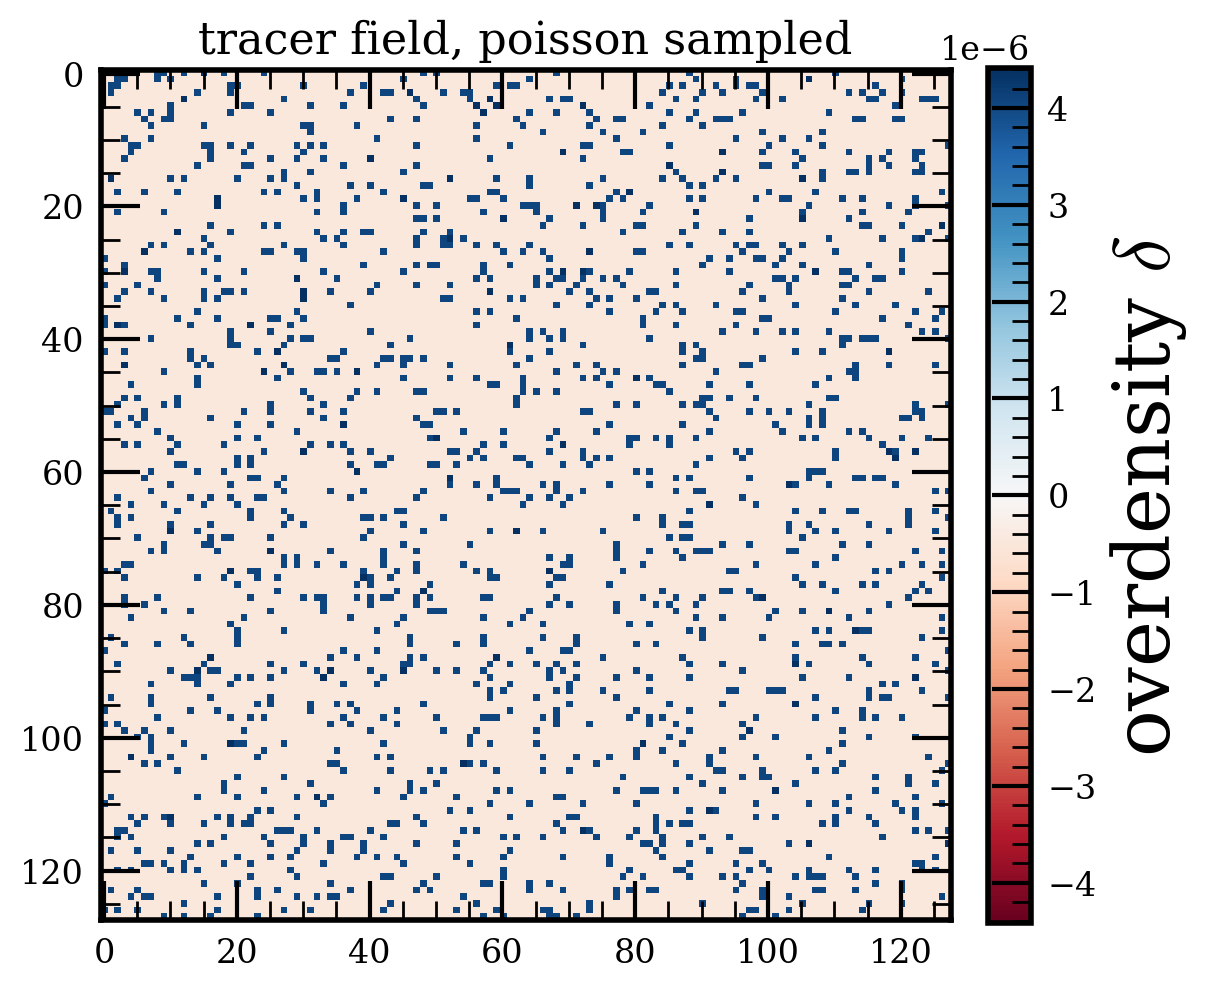

In [47]:
plotter.plot_overdensity_field(tracer_field_poisson, title='tracer field, poisson sampled')

In [36]:
box_size = 1000.0
pk_obj_poisson = cs.compute_pk(tracer_field_poisson, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 16:56:49,865 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 16:56:49,939 bacco.statistics :  ...done in 0.0739 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -0.000681843 (grid1) -0.000681843 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013952 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043105 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays


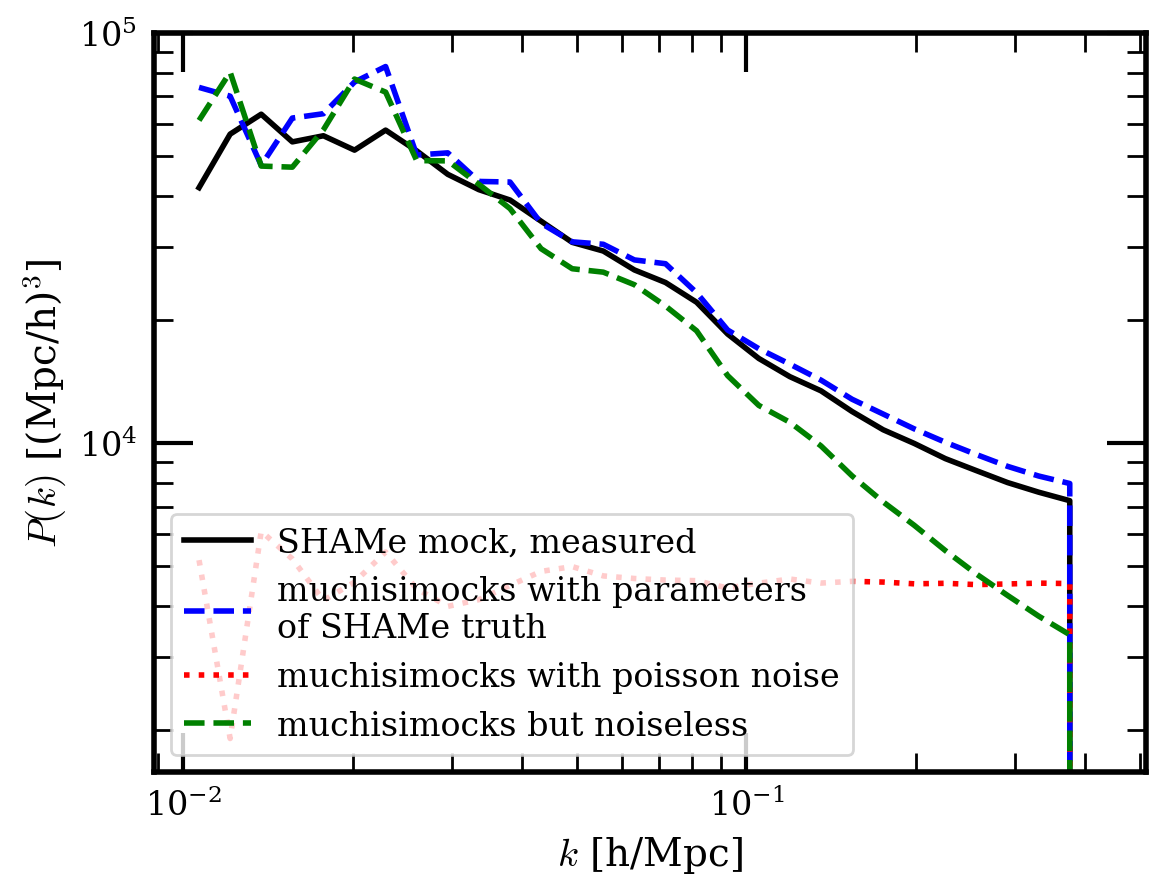

In [37]:
plt.plot(k_mock[0], y_mock[0], color='black', label='SHAMe mock, measured', lw=2)
plt.plot(pk_obj['k'], pk_obj['pk'], color='blue', ls='--', label='muchisimocks with parameters\nof SHAMe truth', lw=2)
plt.plot(pk_obj_poisson['k'], pk_obj_poisson['pk'], color='red', ls=':', label='muchisimocks with poisson noise', lw=2)
plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='green', ls='--', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

### loop over number densities

Load SHAMe data

In [3]:
tags_mock = ['_nbar0.00011', '_nbar0.00022', '_nbar0.00054']

k_mock_arr, y_mock_arr, y_err_mock_arr = [], [], []
for tag_mock in tags_mock:
    data_mode_test = 'shame'
    tag_data_train = None # this is used for mask; we get it below 
    statistics = ['pk', 'bispec']
    k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)
    k_mock_arr.append(k_mock)
    y_mock_arr.append(y_mock)
    y_err_mock_arr.append(y_err_mock)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


Load bias fields, make noiseless field 

In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
tag_mock = None # cosmo is the same for all shame mocks
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
n_grid_orig = 512 # this is for the muchisimocks pipeline which is 512, even tho the shame tracer field was diff (n_grid_orig_mock)
tracer_field_noiseless = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                n_grid_norm=n_grid_orig)

Add noise

In [7]:
noise_field_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    nbar = float(tag_mock.split('nbar')[-1])

    n_grid = 128
    box_size = 1000.0  # Mpc/h
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)

    rng = np.random.default_rng(seed=42)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    noise_field_arr.append(noise_field)

In [25]:
for i, tag_mock in enumerate(tags_mock):
    nbar = float(tag_mock.split('nbar')[-1])
    print(nbar)

0.00011
0.00022
0.00054


In [8]:
tracer_field_arr = []
for i, tag_mock in enumerate(tags_mock):
    A_noise = 1
    tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                          noise_field=noise_field_arr[i], A_noise=A_noise, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

Compute statistics

In [9]:
box_size = 1000.0
pk_obj_noiseless = cs.compute_pk(tracer_field_noiseless, cosmo, box_size,
                        n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-11-13 18:32:24,713 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 18:32:26,282 bacco.statistics :  ...done in 1.57 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.015515 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043594 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000130 secs
bacco.power : Deallocating arrays


In [10]:
pk_obj_arr = []
for i, tag_mock in enumerate(tags_mock):
    tracer_field = tracer_field_arr[i]
    pk_obj = cs.compute_pk(tracer_field, cosmo, box_size,
                            n_threads=1, fn_stat=None)
    pk_obj_arr.append(pk_obj)

Computing pk, using n_grid =  128


2025-11-13 18:32:42,767 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 18:32:42,841 bacco.statistics :  ...done in 0.074 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00241 (grid1) 1.00241 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013668 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042044 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-13 18:32:42,842 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-13 18:32:42,923 bacco.statistics :  ...done in 0.0806 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013772 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041963 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-13 18:32:42,924 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00109 (grid1) 1.00109 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013826 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042252 sec
bacco.power : Starting Fourier loop 


2025-11-13 18:32:43,005 bacco.statistics :  ...done in 0.0809 s


bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays


In [ ]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.20 s


In [12]:
bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [13]:
bspec_arr, bk_corr_arr = [], []
for i, tag_mock in enumerate(tags_mock):
    tracer_field = tracer_field_arr[i]
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field)
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [14]:
box_size_mock = 1024.0
import process_catalogs as pc
n_grid_mock = pc.round_to_nearest_even(box_size_mock / (box_size/n_grid))
print("n_grid_mock: ", n_grid_mock)

n_grid_mock:  132


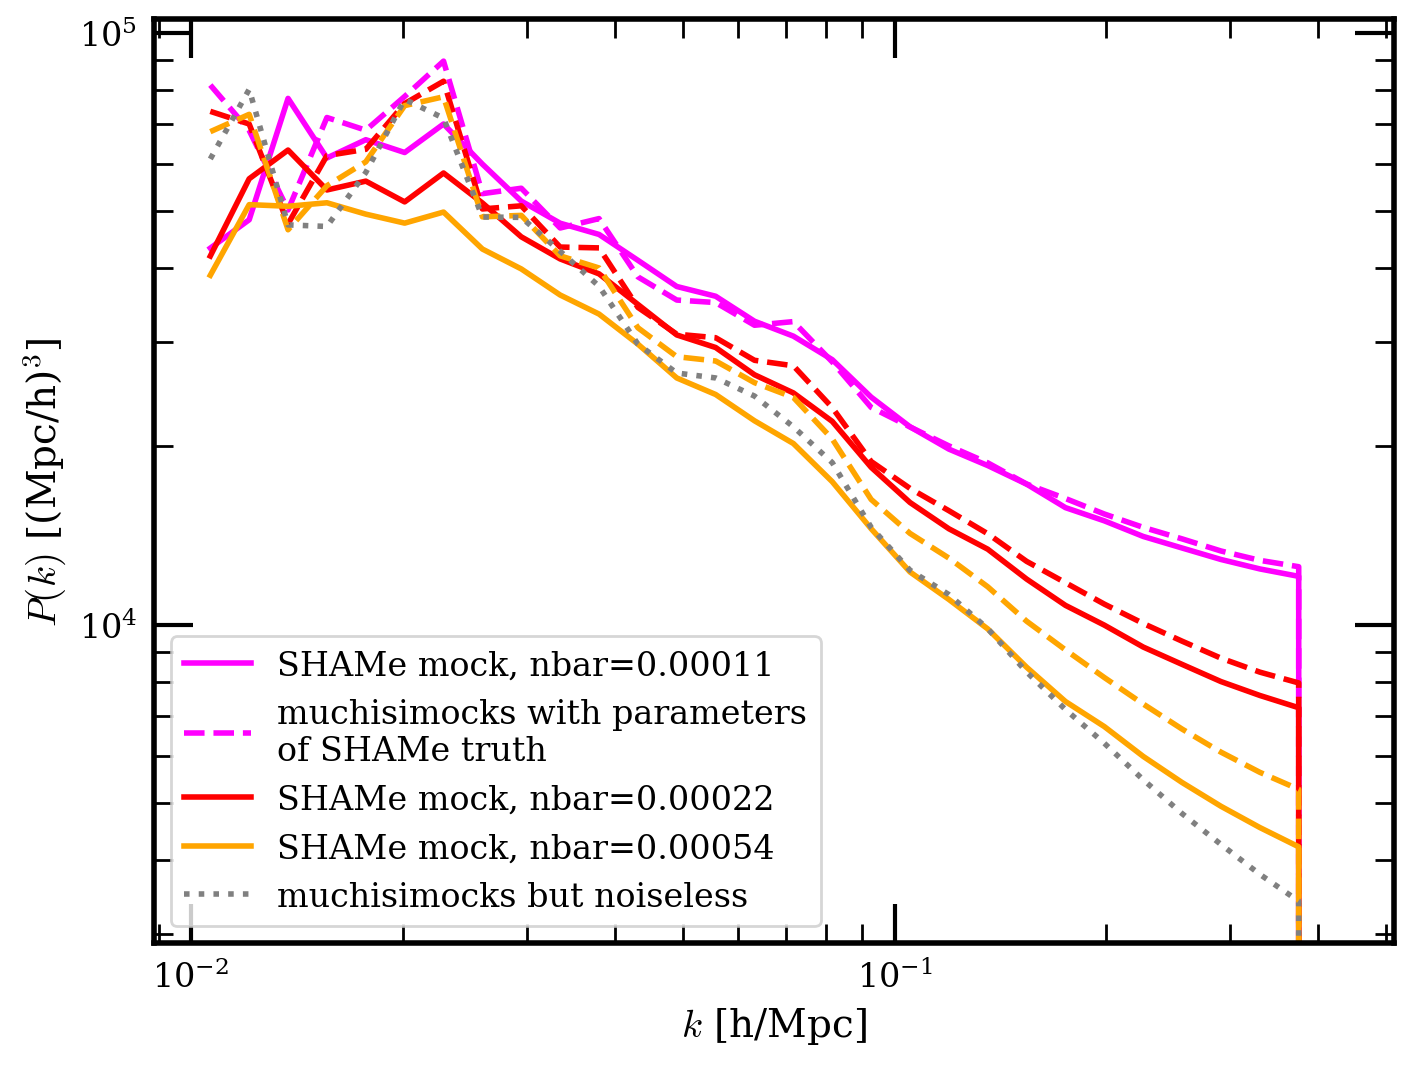

In [24]:
plt.figure(figsize=(8,6))
colors = ['magenta', 'red', 'orange']
for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]
    pk_obj = pk_obj_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    plt.plot(k_mock[0], y_mock[0], color=colors[i], label=label, lw=2)
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
    else:
        label_muchisimocks = None
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=label_muchisimocks, lw=2)
    
plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='grey', ls=':', label='muchisimocks but noiseless', lw=2)
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

2097152 2299968


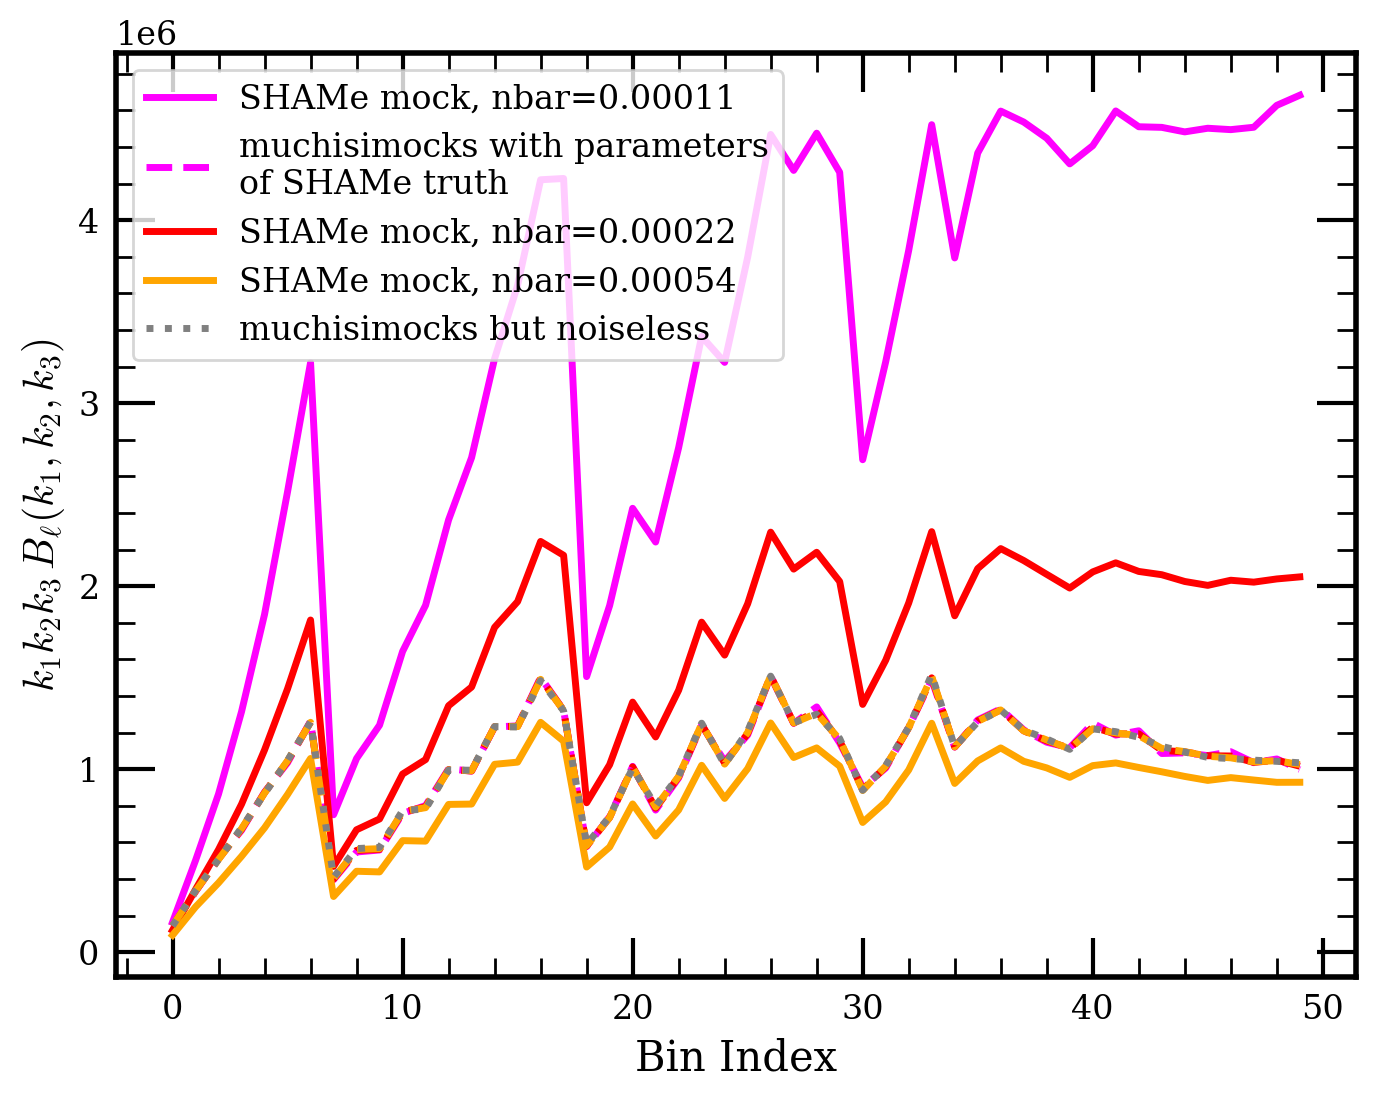

In [23]:
plt.figure(figsize=(8,6))

k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]
    bspec = bspec_arr[i]
    bk_corr = bk_corr_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
    else:
        label_muchisimocks = None
    plt.plot(y_mock[1], color=colors[i], label=label)
    plt.plot(norm**3 * weight*bk_corr['b0'], color=colors[i], ls='--', label=label_muchisimocks)
plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='grey', ls=':', label='muchisimocks but noiseless')


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

## Try advecting noise from Lagrangian to Eulerian space

In [7]:
nbar_fid = 0.00022

def gen_noise_field(nbar_fid, n_grid=128, box_size=1000.0, seed=42):
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

    rng = np.random.default_rng(seed=seed)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    return noise_field

In [ ]:
noise_field_fid = gen_noise_field(nbar_fid)

In [ ]:
# cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

# box_size = 1000.0
# n_grid = 128
# seed = 420
# expfactor = 1.0
# sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, Seed=seed,
#                                                     FixedInitialAmplitude=False, InitialPhase=0, 
#                                                     expfactor=expfactor, LPT_order=1, order_by_order=None,
#                                                     phase_type=1, ngenic_phases=True, return_disp=True, 
#                                                     sphere_mode=0)

2025-11-16 07:58:46,935 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2025-11-16 07:58:46,935 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2025-11-16 07:58:46,936 bacco.sims : Initialising simulation Default
2025-11-16 07:58:46,936 bacco.sims : ...done in 0.000744 s
2025-11-16 07:58:50,730 bacco.scaler : Adding displacement field with a vel-factor=52.128005


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =420 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =420 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.128005 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [ ]:
# grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

In [ ]:
# pred_pos = bacco.scaler.add_displacement(None,
#                                 disp_field,
#                                 box=box_size,
#                                 pos=grid.reshape(-1,3),
#                                 vel=None,
#                                 vel_factor=0,
#                                 verbose=True)[0]

2025-11-16 07:58:55,401 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [ ]:
dir_mocks = '/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000_rerun'
fn_disp = 
pred_pos = 

In [15]:
noise_field_fid_eul = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pred_pos, 
                                mass = (noise_field_fid).flatten(), deposit_method='cic', 
                                interlacing=False)
noise_field_fid_eul = np.squeeze(noise_field_fid_eul)

2025-11-16 07:58:56,607 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
2025-11-16 07:58:56,614 bacco.statistics : starting deposit 1
2025-11-16 07:58:56,631 bacco.statistics :  mesh done in 0.0236 s


bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (2097152 with mass)


In [16]:
noise_field_fid_eul.shape

(128, 128, 128)

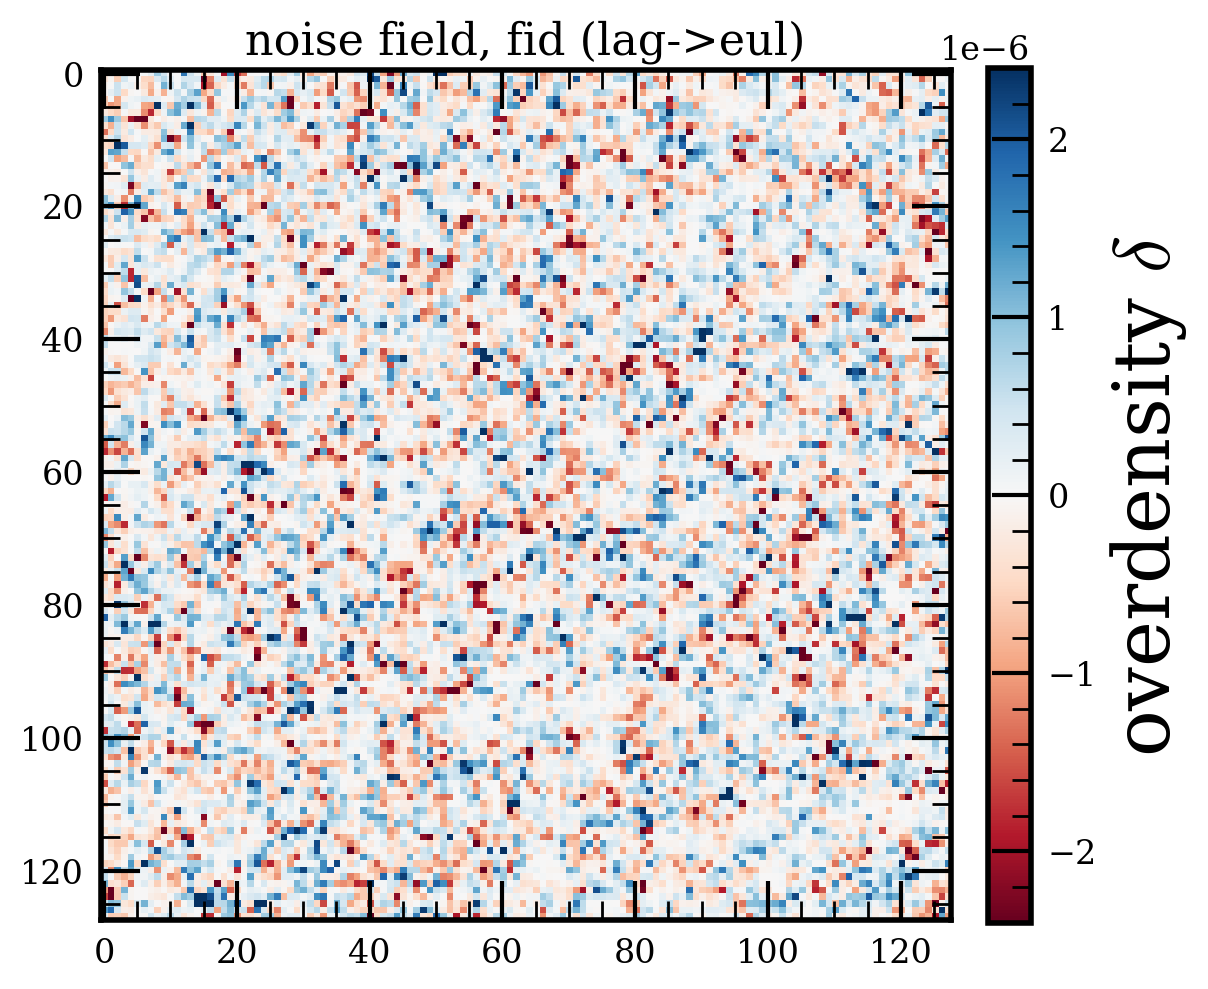

In [17]:
plotter.plot_overdensity_field(noise_field_fid_eul, title='noise field, fid (lag->eul)')

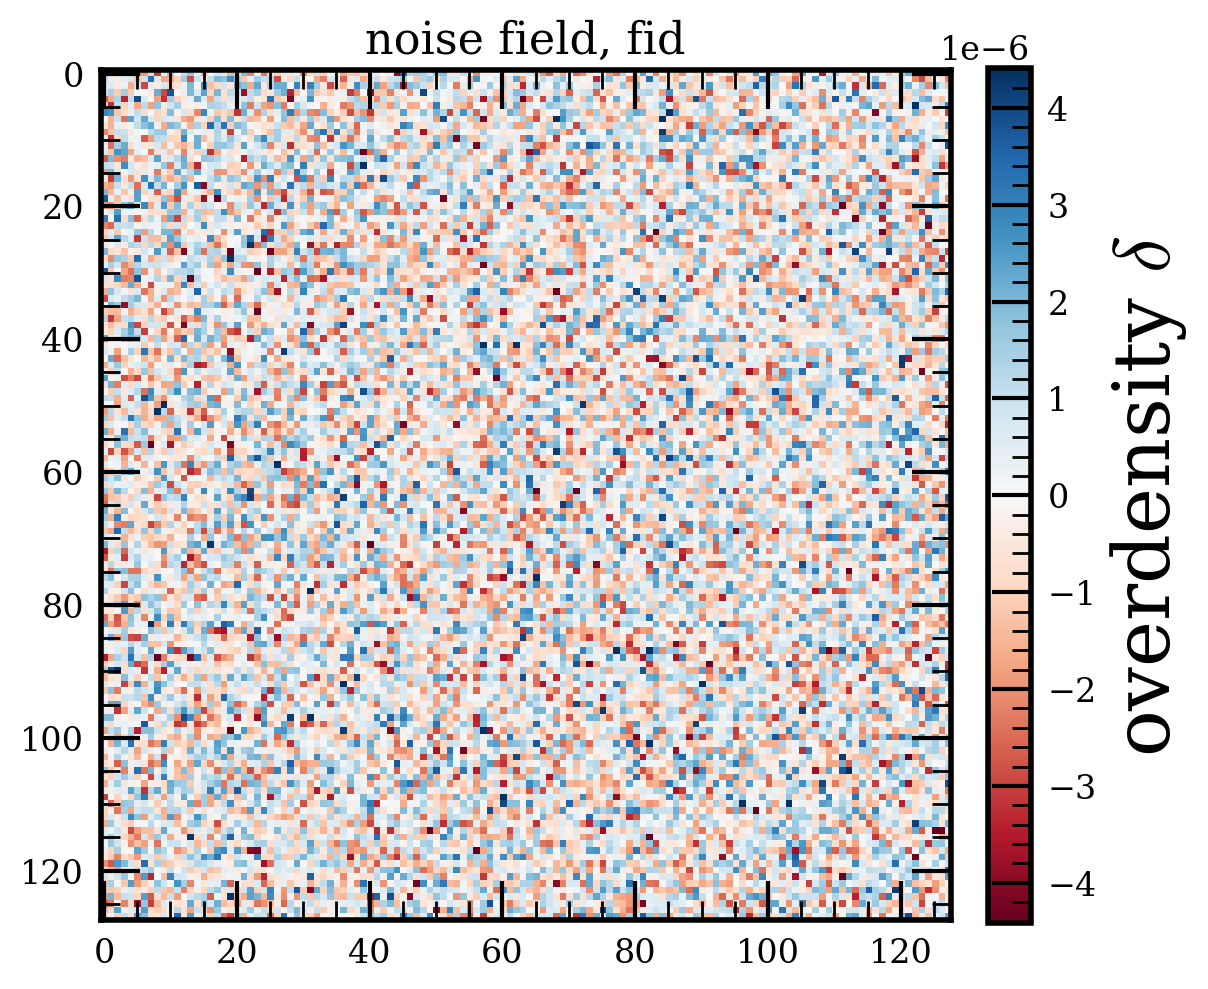

In [18]:
plotter.plot_overdensity_field(noise_field_fid, title='noise field, fid')

In [28]:
pk_obj_noise = cs.compute_pk(noise_field_fid, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-16 08:00:41,393 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-16 08:00:42,511 bacco.statistics :  ...done in 1.12 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014644 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041569 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000119 secs
bacco.power : Deallocating arrays


In [29]:
pk_obj_noiseeul = cs.compute_pk(noise_field_fid_eul, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-16 08:00:49,415 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-16 08:00:49,490 bacco.statistics :  ...done in 0.0741 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013928 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042245 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays


In [20]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.23 s


In [21]:
bspec_noiseeul, bk_corr_noiseeul = cs.compute_bispectrum(base, noise_field_fid_eul)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [22]:
bspec_noise, bk_corr_noise = cs.compute_bispectrum(base, noise_field_fid)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


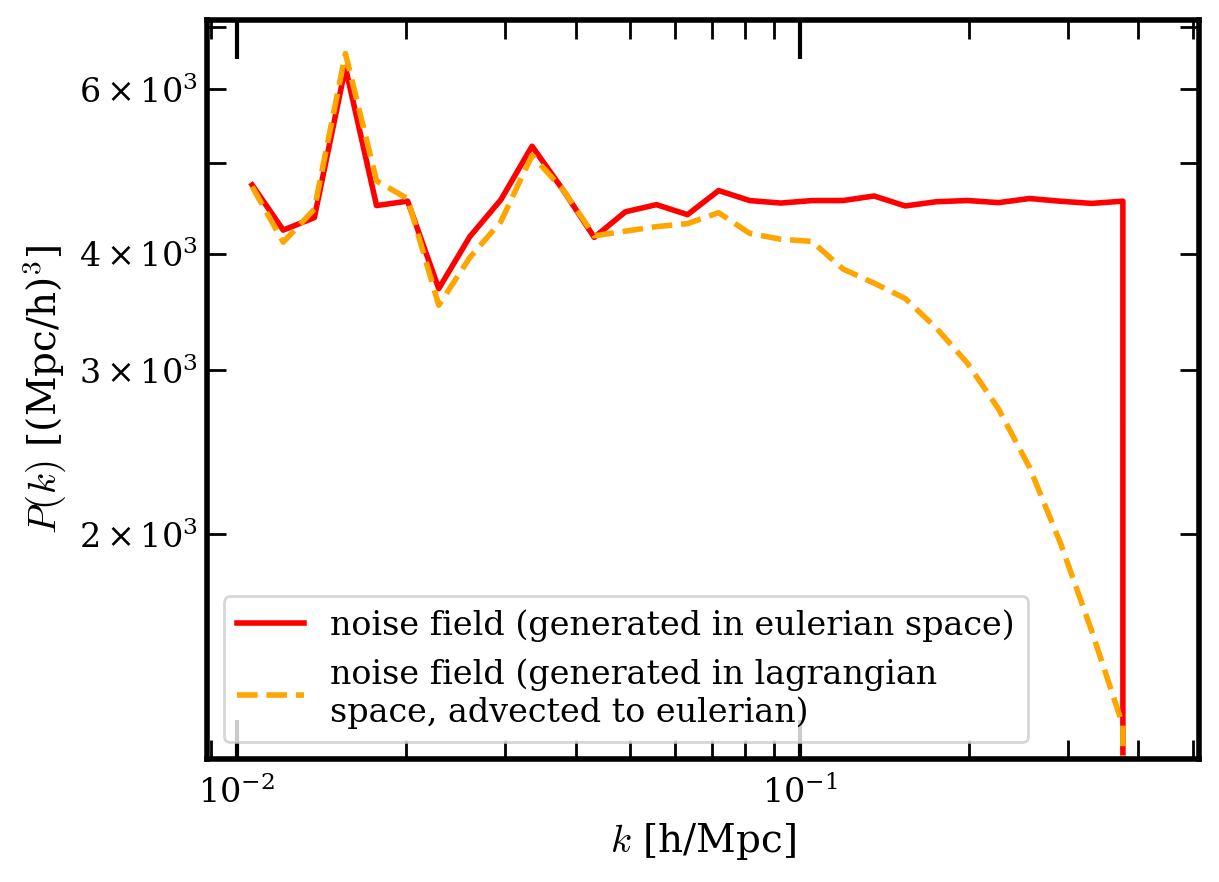

In [34]:
plt.plot(pk_obj_noise['k'], pk_obj_noise['pk'], color='red', ls='-', label='noise field (generated in eulerian space)', lw=2)
plt.plot(pk_obj_noiseeul['k'], pk_obj_noiseeul['pk'], color='orange', ls='--', label='noise field (generated in lagrangian\nspace, advected to eulerian)', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

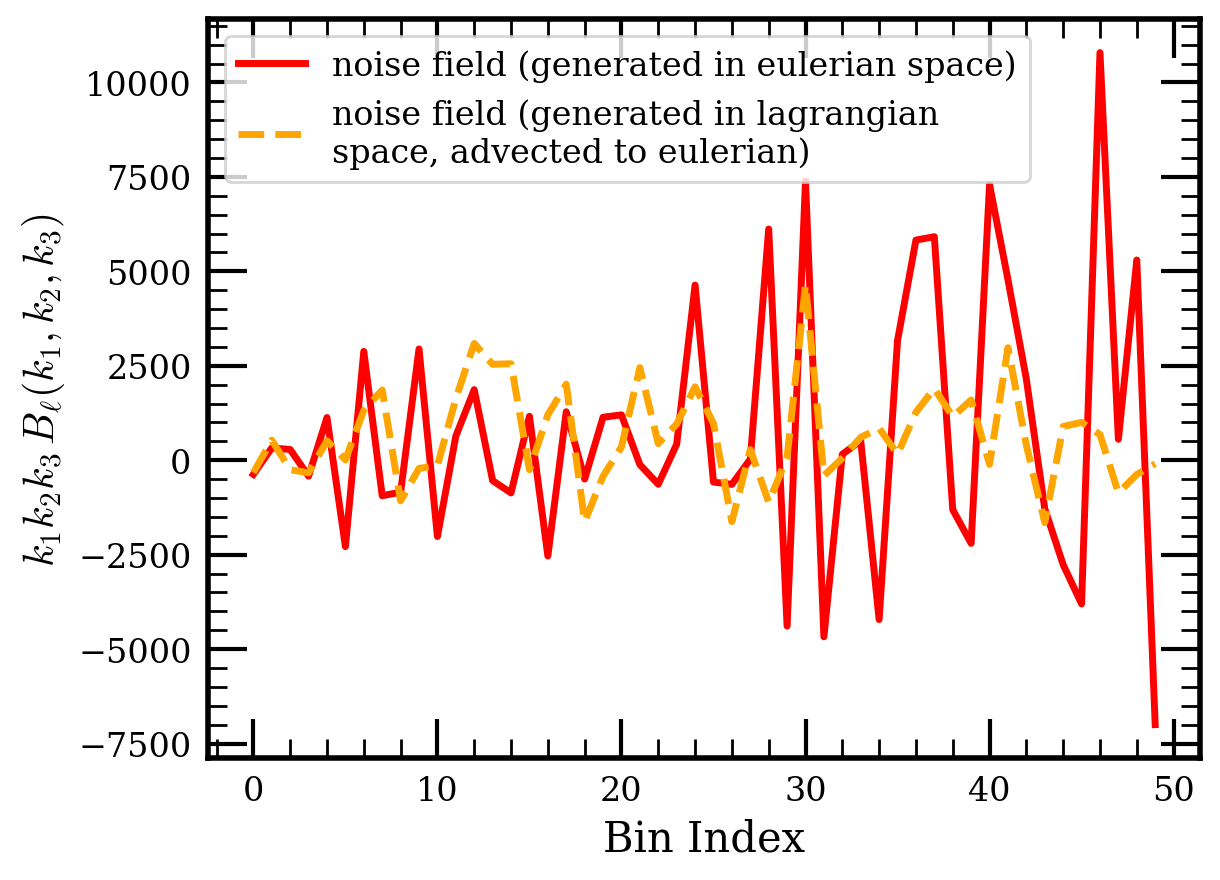

In [35]:
k123 = bspec_noiseeul.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3

plt.plot(norm**3 * weight*bk_corr_noise['b0'], color='red', ls='-', label='noise field (generated in eulerian space)')
plt.plot(norm**3 * weight*bk_corr_noiseeul['b0'], color='orange', ls='--', label='noise field (generated in lagrangian\nspace, advected to eulerian)')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)

In [36]:
A_noise = 1
tracer_field_noiseless = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                A_noise=A_noise, n_grid_norm=n_grid_orig)

In [24]:
A_noise = 1
tracer_field_noiseeul = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                      noise_field=noise_field_fid_eul, A_noise=A_noise, n_grid_norm=n_grid_orig)

In [ ]:
bspec_tracer_noiseeul, bk_corr_tracer_noiseeul = cs.compute_bispectrum(base, tracer_field_noiseeul)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [37]:
bspec_tracer_noiseless, bk_corr_tracer_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


/tmp/ipykernel_935651/3826726065.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


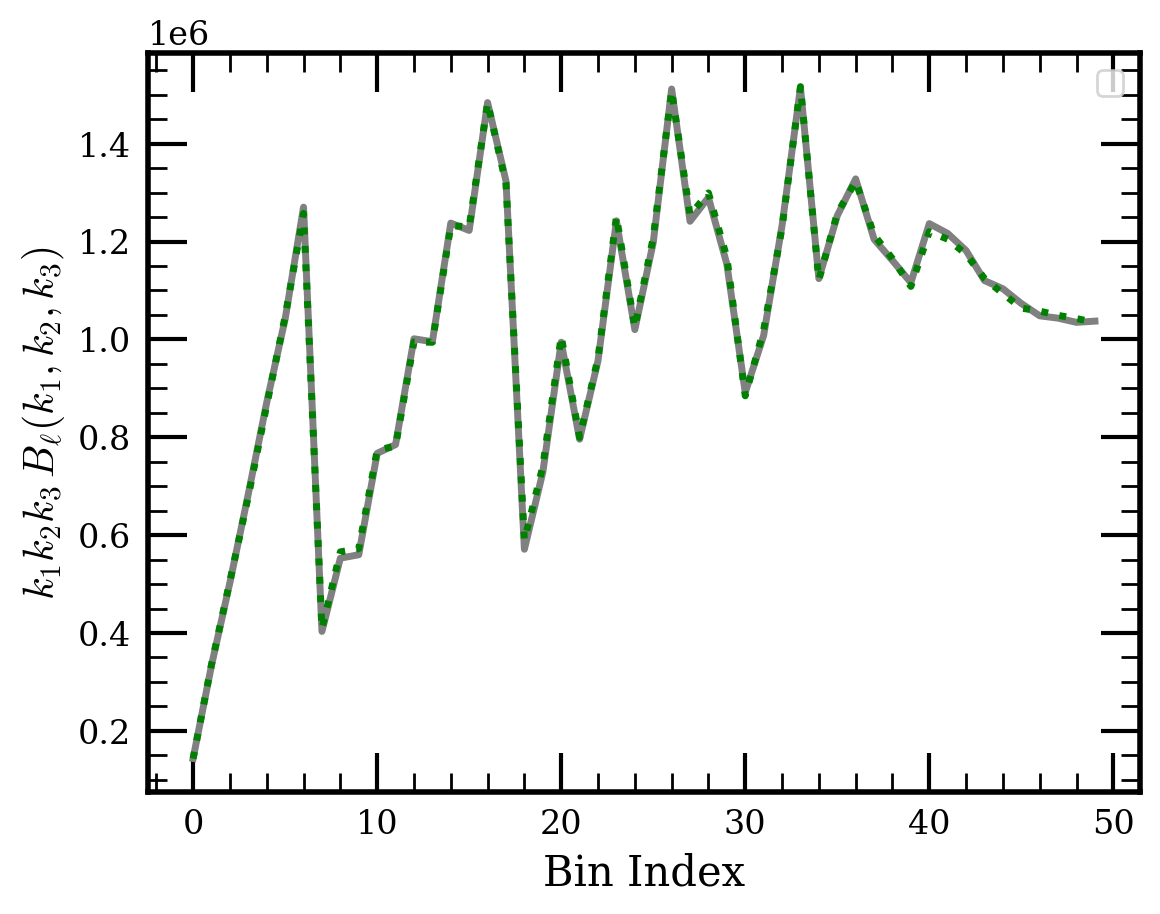

In [39]:
k123 = bspec_noiseeul.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3

plt.plot(norm**3 * weight*bk_corr_tracer_noiseeul['b0'], color='grey', ls='-')
plt.plot(norm**3 * weight*bk_corr_tracer_noiseless['b0'], color='green', ls=':')

# plt.plot(norm**3 * weight*bk_corr_noise['b0'], color='orange', ls='-')
# plt.plot(norm**3 * weight*bk_corr_noiseeul['b0'], color='blue', ls='--')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)